# Wet vs. Dry Ensemble Members

## Import statements

In [44]:
# Imports
import xarray as xr
import dask
import numpy as np
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables
from scipy.ndimage import gaussian_filter
from dask import delayed, compute
from xskillscore import resample_iterations_idx

# Configurations
plt.style.use("dark_background")


## Read in data

In [2]:
from dask.distributed import Client

# Initialize Dask client for better parallel processing
client = Client(threads_per_worker=1)


def load_data(init: str, keyword: str) -> xr.Dataset:
    start_date = "2021-09-02" if init in ["00Z", "01Z"] else "2021-09-01"
    new_dates = xr.cftime_range(
        start=start_date + " " + init[:-1] + ":00:00",
        end="2021-09-02 " + str((int(init[:-1]) + 6) % 24).zfill(2) + ":00:00",
        freq="5min",
    )

    data = xr.open_mfdataset(
        f"/mnt/drive2/wof-runs/post-processed/{init}/wofs_{keyword.upper()}*.nc",
        concat_dim="time",
        combine="nested",
        parallel=True,
    )
    data["time"] = new_dates
    return data

ens = [load_data(i, "ens") for i in ["20Z", "21Z", "22Z", "23Z"]]
ens = [e.assign_coords(lat=e.lat, lon=e.lon, ne=e.ne) for e in ens]

svr = [load_data(i, "svr") for i in ["20Z", "21Z", "22Z", "23Z"]]
svr = [s.assign_coords(lat=s.lat, lon=s.lon, ne=s.ne) for s in svr]

env = [load_data(i, "env") for i in ["20Z", "21Z", "22Z", "23Z"]]
env = [e.assign_coords(lat=e.lat, lon=e.lon, ne=e.ne) for e in env]

In [3]:
def load_wrfwof(init: str, var: str, ne: xr.DataArray) -> xr.Dataset:
    start_date = "2021-09-02" if init in ["00Z","01Z"] else "2021-09-01"
    new_dates = xr.date_range(
        start=start_date + " " + init[:-1] + ":00:00",
        end="2021-09-02 " + str((int(init[:-1]) + 6) % 24).zfill(2) + ":00:00",
        freq="5min",
        use_cftime=True
    )

    def load_single_file(n):
        ds_in = xr.open_mfdataset(
            f"/mnt/drive2/wof-runs/{init}/{var}/wrfwof*{str(n).zfill(2)}",
            decode_times=False, combine="nested", concat_dim="Time", parallel=True,
            chunks={'Time': 10}  # Adjust the chunk size as needed
        )
        ds_in = ds_in.rename({"Time": "time", "south_north": "lat", "west_east": "lon"})
        ds_in["time"] = new_dates
        return ds_in.drop_vars("XTIME")

    ds_list = dask.compute(*[dask.delayed(load_single_file)(n) for n in range(1, 19)])
    ds_concat = xr.concat(ds_list, dim=ne)
    
    # Decode times after concatenation
    ds_concat = xr.decode_cf(ds_concat)
    return ds_concat

# rel_vort = [
#     load_wrfwof(i, "REL_VORT_plev", ens[0].ne) for i in ["20Z", "21Z", "22Z", "23Z"]
# ]

## Other functions

In [4]:
def time_mean(da:xr.DataArray,start:str,end:str) -> xr.DataArray:
    return(da.sel(time=slice(start,end)).mean(dim="time"))

def fix_ne(da:xr.DataArray|xr.Dataset) -> xr.DataArray|xr.Dataset:
    da["ne"] = range(5)
    return(da)

### Plotting attributes

In [5]:
# Isolate 2-dimensional lat and lon
lat = ens[0].xlat.isel(time=0).squeeze()
lon = ens[0].xlon.isel(time=0).squeeze()

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=ens[0].attrs["CEN_LON"],
    central_latitude=ens[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # this is the projection that WoFS uses


plt.style.use("dark_background")

# Get MetPy precipitation colortable
precip_cmap = ctables.registry.get_colortable("precipitation")
dbz_cmap = ctables.registry.get_colortable("NWSReflectivity")

## Create ensembles

In [6]:
# Set desired latitude and longitude
nyc_lat,nyc_lon = 40.7826,-73.9656

# Isolate xlat and xlon for ease of use
lat = ens[0].xlat.isel(time=0)
lon = ens[0].xlon.isel(time=0)

# Calculate the Euclidean distance between lat and lon values and the desired point
distance = np.sqrt((lat-nyc_lat)**2 + (lon-nyc_lon)**2)

# Find where the distance is minimized
nyc_inds = distance.argmin(dim=["NY","NX"])
ny_ind, nx_ind = int(nyc_inds["NY"]),int(nyc_inds["NX"])

In [7]:
# We are going to sort by the area averaged precip
rain_1to2Z = [e.rain.sel(time=slice("2021-09-02 01:05:00",
                                   "2021-09-02 02:00:00")).sum(dim="time") for e in ens]

# Calculate the area average hourly precip for a box around Central Park
aoi_48km = [r.isel(
    lat=slice(ny_ind-8,ny_ind+8),
    lon=slice(nx_ind-8,nx_ind+8)
) for r in rain_1to2Z]
avg_48km = [a.mean(dim=["lat","lon"]) for a in aoi_48km]

In [8]:
# Get the indices of the wettest and driest ensemble members
ne_wet = [a.ne.where(
    a > a.quantile(0.75,dim="ne")).dropna(dim="ne") for a in avg_48km]
ne_dry = [a.ne.where(
    a < a.quantile(0.25,dim="ne")).dropna(dim="ne") for a in avg_48km]

In [9]:
# Select the wettest and driest members

ens_wet = [ens[i].sel(ne=ne_wet[i]).drop_vars("quantile") for i in range(len(ens))]
ens_dry = [ens[i].sel(ne=ne_dry[i]).drop_vars("quantile") for i in range(len(ens))]

svr_wet = [svr[i].sel(ne=ne_wet[i]).drop_vars("quantile") for i in range(len(svr))]
svr_dry = [svr[i].sel(ne=ne_dry[i]).drop_vars("quantile") for i in range(len(svr))]

env_wet = [env[i].sel(ne=ne_wet[i]).drop_vars("quantile") for i in range(len(env))]
env_dry = [env[i].sel(ne=ne_dry[i]).drop_vars("quantile") for i in range(len(env))]

# rel_vort_wet = [rel_vort[i].sel(ne=ne_wet[i]).drop_vars("quantile") for i in
#                 range(len(rel_vort))]
# rel_vort_dry = [rel_vort[i].sel(ne=ne_dry[i]).drop_vars("quantile") for i in
#                 range(len(rel_vort))]

# Make a new init dimension to concatenate the DataArrays
init = xr.DataArray(data=["20Z","21Z","22Z","23Z"],dims="init")
init = init.assign_coords({"init":init})

In [10]:
client.close()  # Close the Dask client

## No PMM

### Functions

In [48]:
def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    copy = da.copy()  # Make a copy of the DataArray
    copy.values = gaussian_filter(
        da.values, sigma=sigma, axes=axes
    )  # Smooth the values
    return copy  # Return the smoothed DataArray

@delayed
def bootstrap_iteration_mean(da, sample_size):
    """Single iteration of bootstrapping"""
    # Get run indices
    run_indices = np.arange(da.run.size)
    
    # Sample without replacement
    sample1_indices = np.random.choice(run_indices, sample_size, replace=False)
    sample2_indices = np.random.choice(run_indices, sample_size, replace=False)

    # Select corresponding runs
    sample1 = da.isel(run=sample1_indices)
    sample2 = da.isel(run=sample2_indices)

    # Compute PMM for each sample
    mean1 = sample1.mean(dim="run")  # Compute mean
    mean2 = sample2.mean(dim="run")  # Compute mean

    # Compute difference of PMMs
    diff = mean1 - mean2
    return diff


def bootstrap_mean_difference(
    da: xr.DataArray, sample_size: int, iterations: int
) -> xr.DataArray:
    """Perform bootstrapping and compute differences of PMM"""
    tasks = [bootstrap_iteration_mean(da, sample_size) for _ in range(iterations)]
    results = compute(*tasks)
    return xr.concat(results, dim="iteration")

### MSLP

In [14]:
mslp_all = smooth(
    xr.concat([e.mslp for e in env], dim=init).stack(run=("ne", "init"))
).chunk({"run": -1})
mslp_wet = smooth(
    xr.concat([fix_ne(e.mslp) for e in env_wet], dim=init).stack(run=("ne", "init"))
)
mslp_dry = smooth(
    xr.concat([fix_ne(e.mslp) for e in env_dry], dim=init).stack(run=("ne", "init"))
)

In [15]:
# time bounds
start = "2021-09-01 23:00:00"
end = "2021-09-02 02:00:00"

# Find indices of minimum SLP location::""
inds_wet = (
    mslp_wet.mean(dim="run", skipna=True)
    .sel(time=slice(start, end))
    .argmin(dim=["lat", "lon"])
)
inds_dry = (
    mslp_dry.mean(dim="run", skipna=True)
    .sel(time=slice(start, end))
    .argmin(dim=["lat", "lon"])
)

# Obtain lat and lon values from those points
lats_wet = lat.values[inds_wet["lat"], inds_wet["lon"]]
lons_wet = lon.values[inds_wet["lat"], inds_wet["lon"]]

lats_dry = lat.values[inds_dry["lat"], inds_dry["lon"]]
lons_dry = lon.values[inds_dry["lat"], inds_dry["lon"]]

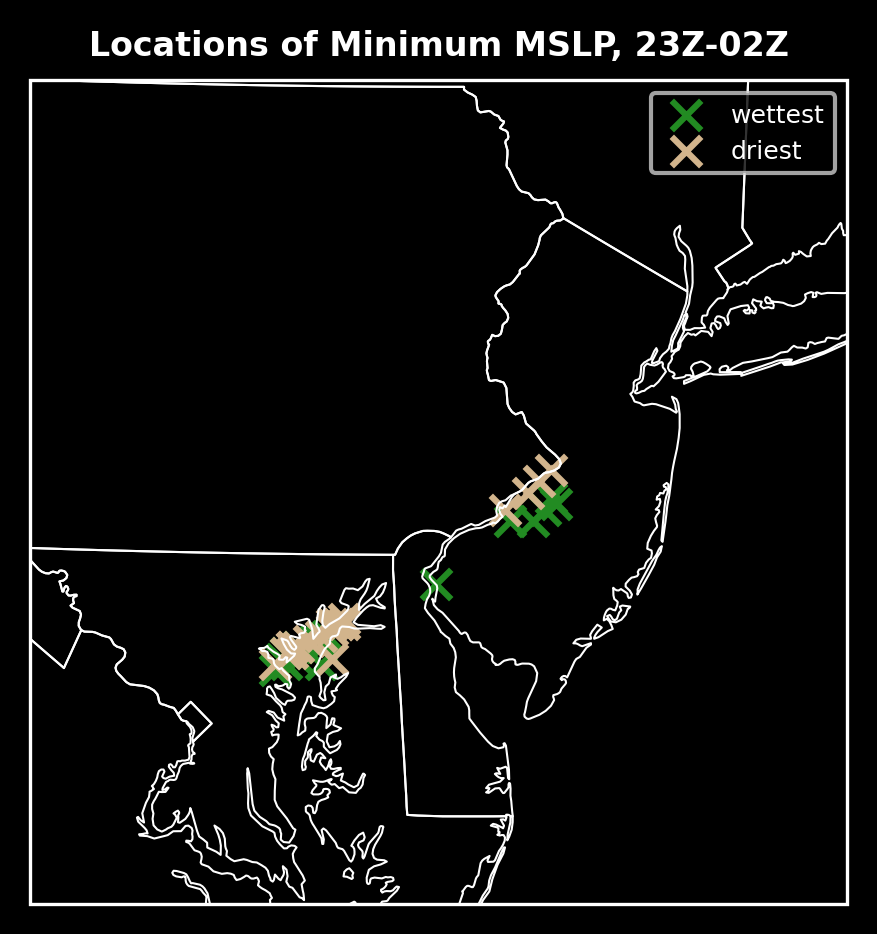

In [16]:
# Let's plot it up
fig, ax = plt.subplots(
    1,
    1,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(3, 3),
    sharey=True,
)

ax.scatter(
    lons_wet[::2],
    lats_wet[::2],
    transform=ccrs.PlateCarree(),
    s=50,
    color="forestgreen",
    marker="x",
    label="wettest",
)

ax.scatter(
    lons_dry[::2],
    lats_dry[::2],
    transform=ccrs.PlateCarree(),
    s=50,
    color="tan",
    marker="x",
    label="driest",
)

ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
ax.set_extent([-78, -73, 38, 42])
ax.legend(loc="best", fontsize=6)

ax.set_title("Locations of Minimum MSLP, 23Z-02Z",fontweight="bold",fontsize=8)

plt.show()

/tmp/ipykernel_4100578/1700733764.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return scat_wet, scat_dry, *contour.collections
/tmp/ipykernel_4100578/1700733764.py:46: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for coll in contour.collections:
/tmp/ipykernel_4100578/1700733764.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return scat_wet, scat_dry, *contour.collections
/tmp/ipykernel_4100578/1700733764.py:46: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for coll in contour.collections:
/tmp/ipykernel_4100578/1700733764.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 

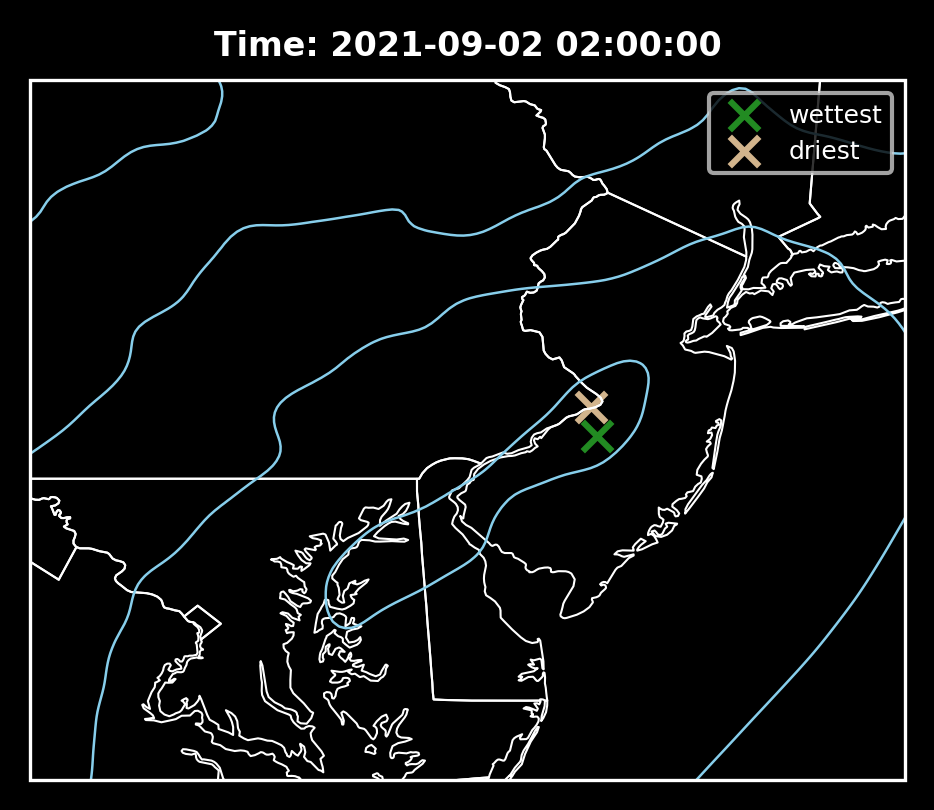

In [17]:
from matplotlib.animation import FuncAnimation

# Assuming lat and lon variables are one-dimensional numpy arrays with the dimension being time
# lats_wet, lons_wet, lats_dry, lons_dry are arrays with time series of coordinates
mslp_to_contour = mslp_all.sel(time=slice(start, end)).mean(dim="run")

# Set up the figure and axis
fig, ax = plt.subplots(
    1,
    1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    dpi=300,
    layout="constrained",
    figsize=(3, 3),
)

# Add features to the plot
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
# Optionally set the extent
ax.set_extent([-78, -73, 38, 42])

# Initialize the scatter plot with empty data
scat_wet = ax.scatter(
    [],
    [],
    transform=ccrs.PlateCarree(),
    s=50,
    color="forestgreen",
    marker="x",
    label="wettest",
)
scat_dry = ax.scatter(
    [], [], transform=ccrs.PlateCarree(), s=50, color="tan", marker="x", label="driest"
)

# Add legend
ax.legend(loc="best", fontsize=6)

contour = None


# Function to update the scatter plot for each frame
def update(frame):
    global contour
    if contour:
        for coll in contour.collections:
            coll.remove()  # Remove the old contours
    scat_wet.set_offsets([lons_wet[frame], lats_wet[frame]])
    scat_dry.set_offsets([lons_dry[frame], lats_dry[frame]])

    # get mslp data
    mslp_data = mslp_to_contour.isel(time=frame)

    # Create the contour plot
    contour = ax.contour(
        lon,
        lat,
        mslp_data,
        transform=ccrs.PlateCarree(),
        colors="skyblue",
        levels=range(980, 1020, 4),
        linewidths=0.6,
    )

    current_time = str(mslp_data.time.values)
    ax.set_title(f"Time: {current_time}",fontsize=8,fontweight="bold")

    return scat_wet, scat_dry, *contour.collections


# Create the animation
ani = FuncAnimation(fig, update, frames=len(lats_wet), interval=500, blit=True)

# Save or display the animation
ani.save("scatter_animation.gif")
plt.show()

Text(0.5, 0.98, 'Ens. Mean. MSLP (contours) and Min. MSLP (x) for Wettest and Driest Members')

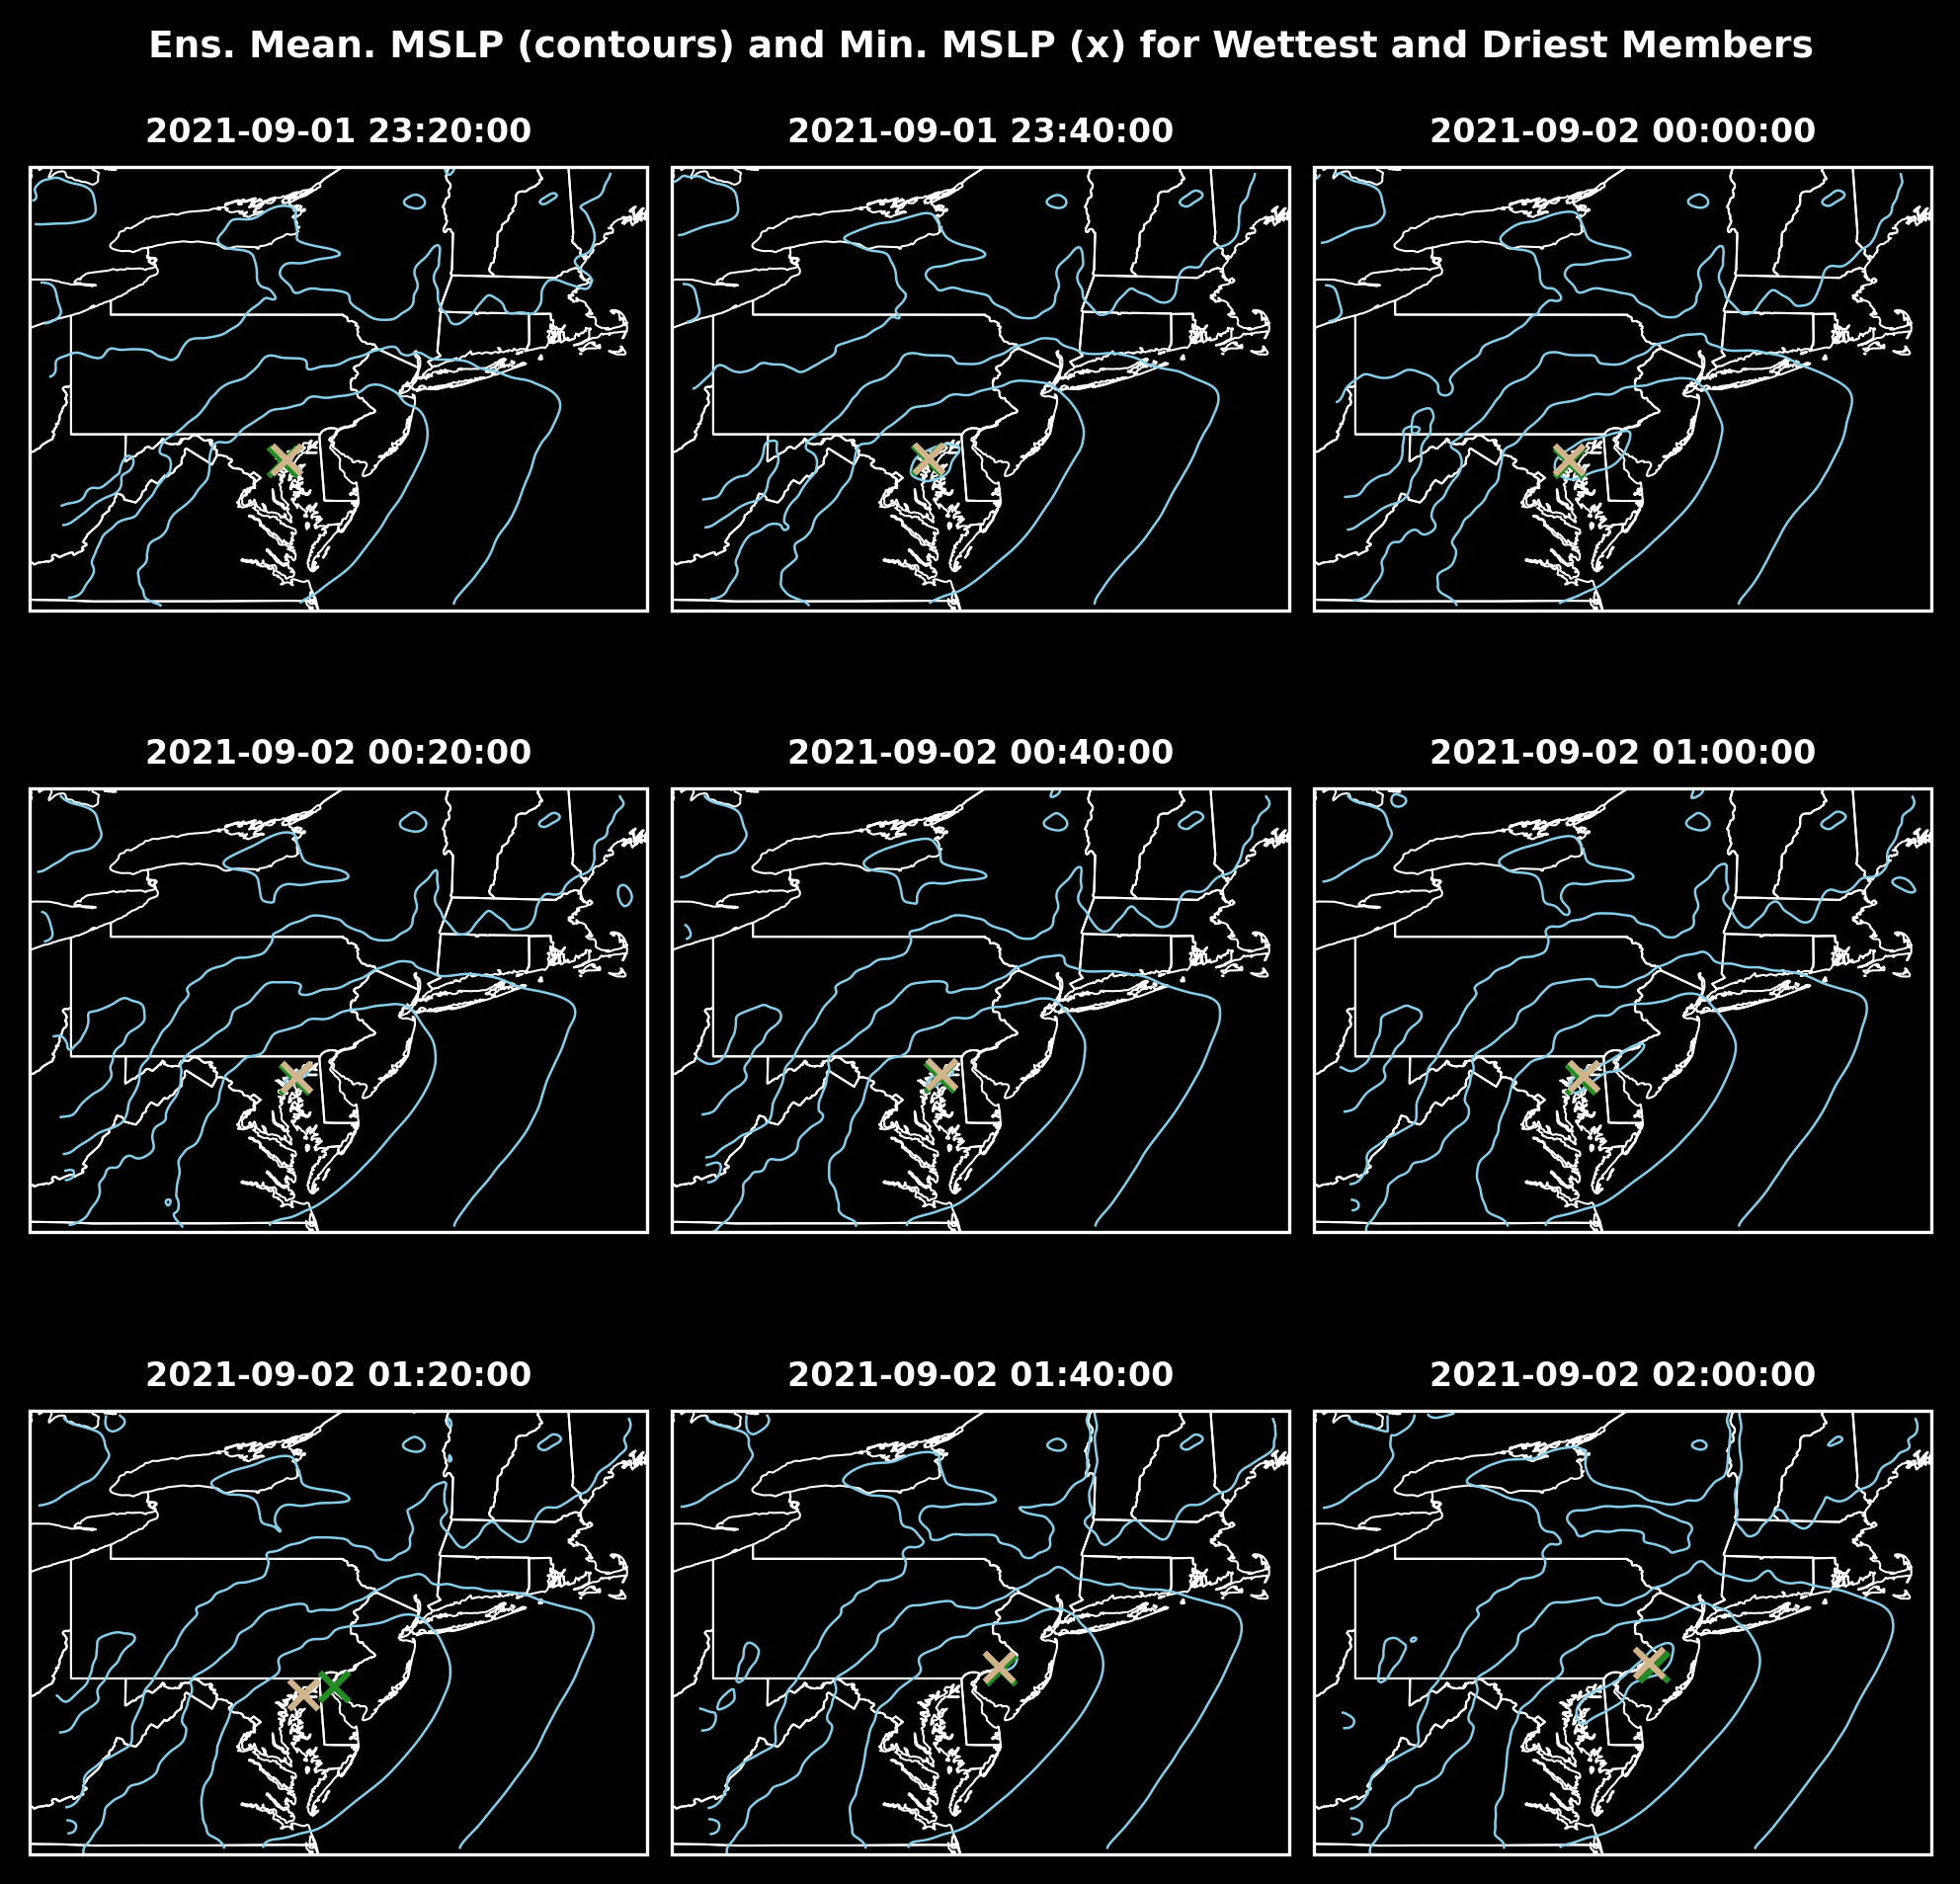

In [39]:
times = [
    "2021-09-01 23:20:00",
    "2021-09-01 23:40:00",
    "2021-09-02 00:00:00",
    "2021-09-02 00:20:00",
    "2021-09-02 00:40:00",
    "2021-09-02 01:00:00",
    "2021-09-02 01:20:00",
    "2021-09-02 01:40:00",
    "2021-09-02 02:00:00",
]
mslp_to_contour = [mslp_all.mean(dim="run").sel(time=t).squeeze() for t in times]

# Set up the figure and axis
fig, axes = plt.subplots(
    3,
    3,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    dpi=300,
    layout="constrained",
    figsize=(6.5, 6.5),
)

for i, ax in enumerate(axes.flat):

    # Get time index
    # Contour the mslp_to_contour
    c = ax.contour(
        lon,
        lat,
        mslp_to_contour[i],
        transform=ccrs.PlateCarree(),
        colors="skyblue",
        levels=range(980, 1020, 4),
        linewidths=0.6,
        zorder=2,
    )

    # Add the MSLP minimum to the plot
    s1 = ax.scatter(
        lons_wet[i * 4],
        lats_wet[i * 4],
        transform=ccrs.PlateCarree(),
        s=50,
        color="forestgreen",
        marker="x",
        label="wettest",
        zorder=3,
    )

    s2 = ax.scatter(
        lons_dry[i * 4],
        lats_dry[i * 4],
        transform=ccrs.PlateCarree(),
        s=50,
        color="tan",
        marker="x",
        label="driest",
        zorder=3,
    )

    # Add features to the plot
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=1)

    # Add time as title
    ax.set_title(str(times[i]), fontsize=8, fontweight="bold")

# Add suptitle
plt.suptitle(
    "Ens. Mean. MSLP (contours) and Min. MSLP (x) for Wettest and Driest Members",
    fontsize=9,
    fontweight="bold",
)

plt.show()

In [43]:
# SLP differences
mslp_wet_01 = mslp_wet.sel(time="2021-09-02 01:00:00").squeeze()
mslp_dry_01 = mslp_dry.sel(time="2021-09-02 01:00:00").squeeze()
mslp_all_01 = mslp_all.sel(time="2021-09-02 01:00:00").squeeze()

mslp_diff_01 = mslp_wet_01 - mslp_dry_01

In [60]:
mslp_diff_01.mean(dim="run").min()

<xarray.DataArray 'mslp' ()> Size: 8B
array(-1.21334231)
Coordinates:
    time     object 8B 2021-09-02 01:00:00

In [69]:
# Perform the bootstrapping
result = bootstrap_mean_difference(mslp_all_01, sample_size=20, iterations=1000)

# Compute the results
result_computed = result.compute()

# Create mask for hatching on plot
mslp_mask_01 = (
    mslp_diff_01.mean(dim="run") > result_computed.quantile(0.95, dim="iteration")
) | (mslp_diff_01.mean(dim="run") < result_computed.quantile(0.05, dim="iteration"))

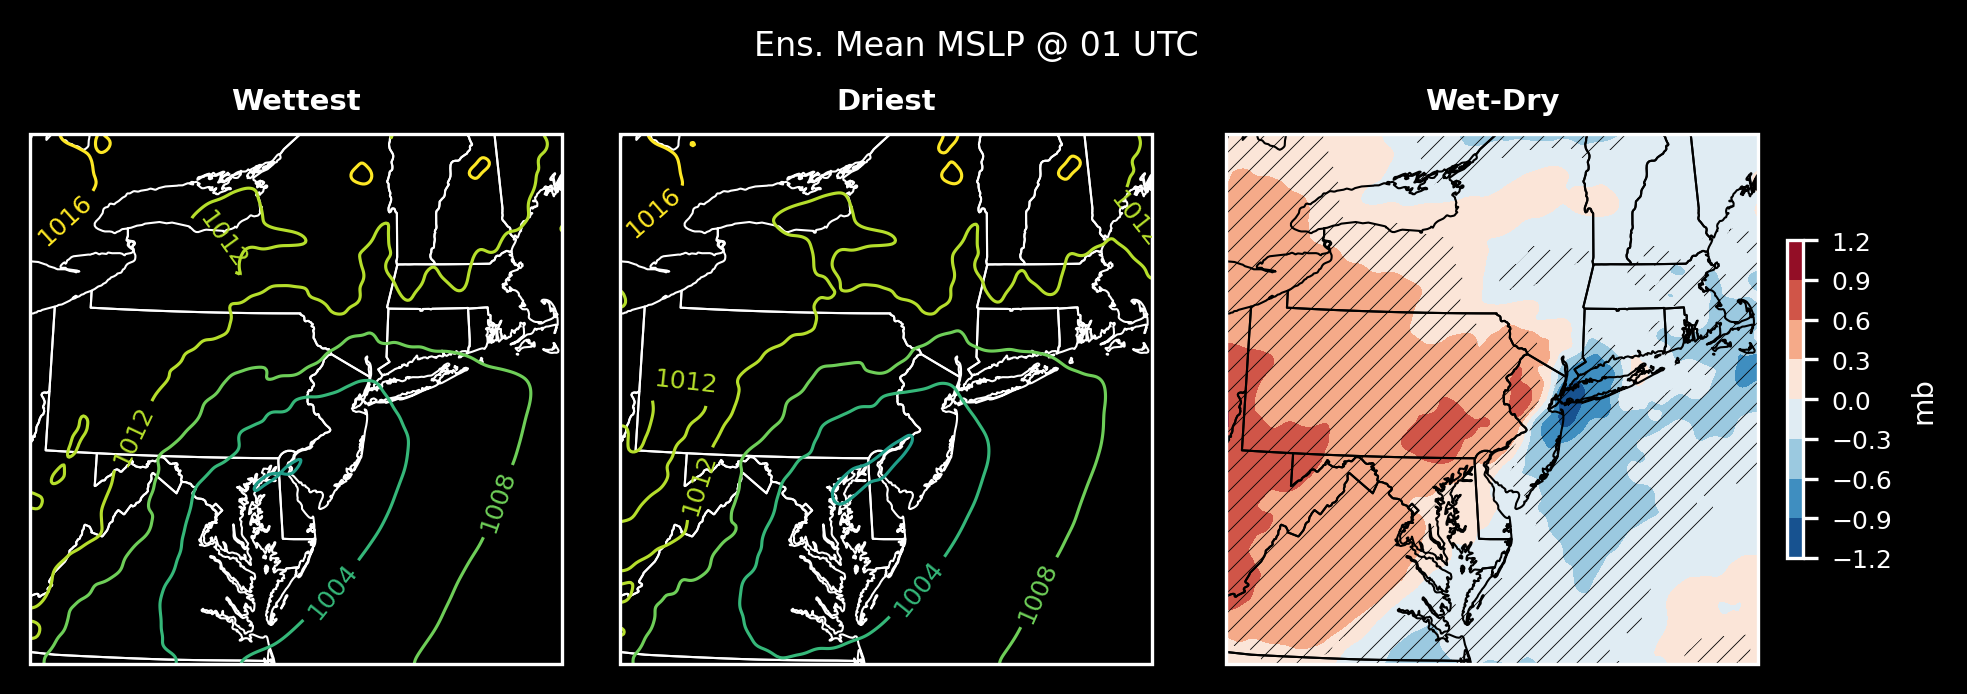

In [75]:
import matplotlib  as mpl
mpl.rcParams['hatch.linewidth'] = 0.2

# Plot pw_hourly_wet, dry, and diff
titles = ["Wettest", "Driest", "Wet-Dry"]

values = [mslp_wet_01, mslp_dry_01, mslp_diff_01]

fig, axes = plt.subplots(
    1,
    3,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(6.5, 2.2),
)

for i, ax in enumerate(axes.flatten()):
    if i != 2:
        c = ax.contour(
            lon,
            lat,
            values[i].mean(dim="run"),
            transform=ccrs.PlateCarree(),
            levels=np.arange(980, 1020, 4),
            linewidths=0.75
        )
        c.clabel(inline=True, fontsize=6, fmt="%d")
        c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
    else:
        c = ax.contourf(
            lon,
            lat,
            values[i].mean(dim="run"),
            transform=ccrs.PlateCarree(),
            levels=np.arange(-1.2,1.3,0.3),
            cmap="RdBu_r",
        )
        # Add hatches in masked area
        ax.contourf(
            lon,
            lat,
            mslp_mask_01,
            transform=ccrs.PlateCarree(),
            levels=[0, 0.5, 1],
            hatches=["", "/////"],
            colors="none",
        )
        c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

        cbar = plt.colorbar(c,ax=ax,shrink=0.6)
        cbar.ax.tick_params(labelsize=6)
    if(i in [2]):
        cbar.set_label("mb",fontsize=7)

    ax.set_title(titles[i],fontsize=7, fontweight="bold")

plt.suptitle("Ens. Mean MSLP @ 01 UTC",fontsize=8)
plt.show()

### CAPE

In [11]:
# Calculate hourly average CAPE in all, wet, and dry ensemble members
# cape_hourly_all = (
#     xr.concat(
#         [s.cape_ml.groupby(s.time.dt.hour).mean(dim="time") for s in svr], dim=init
#     )
#     .stack(run=("ne", "init"))
#     .chunk({"run": -1})
# )

cape_hourly_wet = xr.concat(
    [fix_ne(s.cape_ml.groupby(s.time.dt.hour).mean(dim="time")) for s in svr_wet],  # type: ignore
    dim=init
).stack(run=("ne", "init"))

cape_hourly_dry = xr.concat(
    [fix_ne(s.cape_ml.groupby(s.time.dt.hour).mean(dim="time")) for s in svr_dry], # type: ignore
    dim=init
).stack(run=("ne", "init"))

In [43]:
# Take the time mean of the precipitable water

cape_23to00_all = xr.concat([time_mean(s.cape_ml,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00") for s in svr],dim=init).stack(
                            run=("ne","init")).chunk({"run":-1})
cape_00to01_all = xr.concat([time_mean(s.cape_ml,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00") for s in svr],dim=init).stack(
                            run=("ne","init")).chunk({"run":-1})
cape_23to00_wet = xr.concat([fix_ne(time_mean(s.cape_ml,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00")) for s in svr_wet],dim=init).stack(
                            run=("ne","init"))
cape_00to01_wet = xr.concat([fix_ne(time_mean(s.cape_ml,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00")) for s in svr_wet],dim=init).stack(
                            run=("ne","init"))
cape_23to00_dry = xr.concat([fix_ne(time_mean(s.cape_ml,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00")) for s in svr_dry],dim=init).stack(
                            run=("ne","init"))
cape_00to01_dry = xr.concat([fix_ne(time_mean(s.cape_ml,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00")) for s in svr_dry],dim=init).stack(
                            run=("ne","init"))
    
# Bootstrap!

with ProgressBar():
    set1_23to00 = resample_iterations_idx(
        cape_23to00_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set2_23to00 = resample_iterations_idx(
        cape_23to00_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set1_00to01 = resample_iterations_idx(
        cape_00to01_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set2_00to01 = resample_iterations_idx(
        cape_00to01_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    

[########################################] | 100% Completed | 56.96 s
[########################################] | 100% Completed | 55.59 ss
[####################################### ] | 99% Completed | 40.43 sms

In [12]:
# Get difference of wet and dry cape
cape_diff = cape_hourly_wet - cape_hourly_dry

In [ ]:
# Calculate the mean difference and create bootstrap sample for comparison
cape_diff_23to00 = (cape_23to00_wet - cape_23to00_dry).mean(dim="run")
cape_diff_00to01 = (cape_00to01_wet - cape_00to01_dry).mean(dim="run")
cape_boot_23to00 = set1_23to00 - set2_23to00
cape_boot_00to01 = set1_00to01 - set2_00to01

# # Create mask for hatching on plot
cape_mask_23to00 = (((cape_diff_23to00 > cape_boot_23to00.quantile(0.95,dim="iteration"))|
                   (cape_diff_23to00 < cape_boot_23to00.quantile(0.05,dim="iteration")))&
                   (np.fabs(cape_diff_23to00) > 0.03))
cape_mask_00to01 = (((cape_diff_00to01 > cape_boot_00to01.quantile(0.95,dim="iteration"))|
                   (cape_diff_00to01 < cape_boot_00to01.quantile(0.05,dim="iteration")))&
                   (np.fabs(cape_diff_00to01) > 0.03))

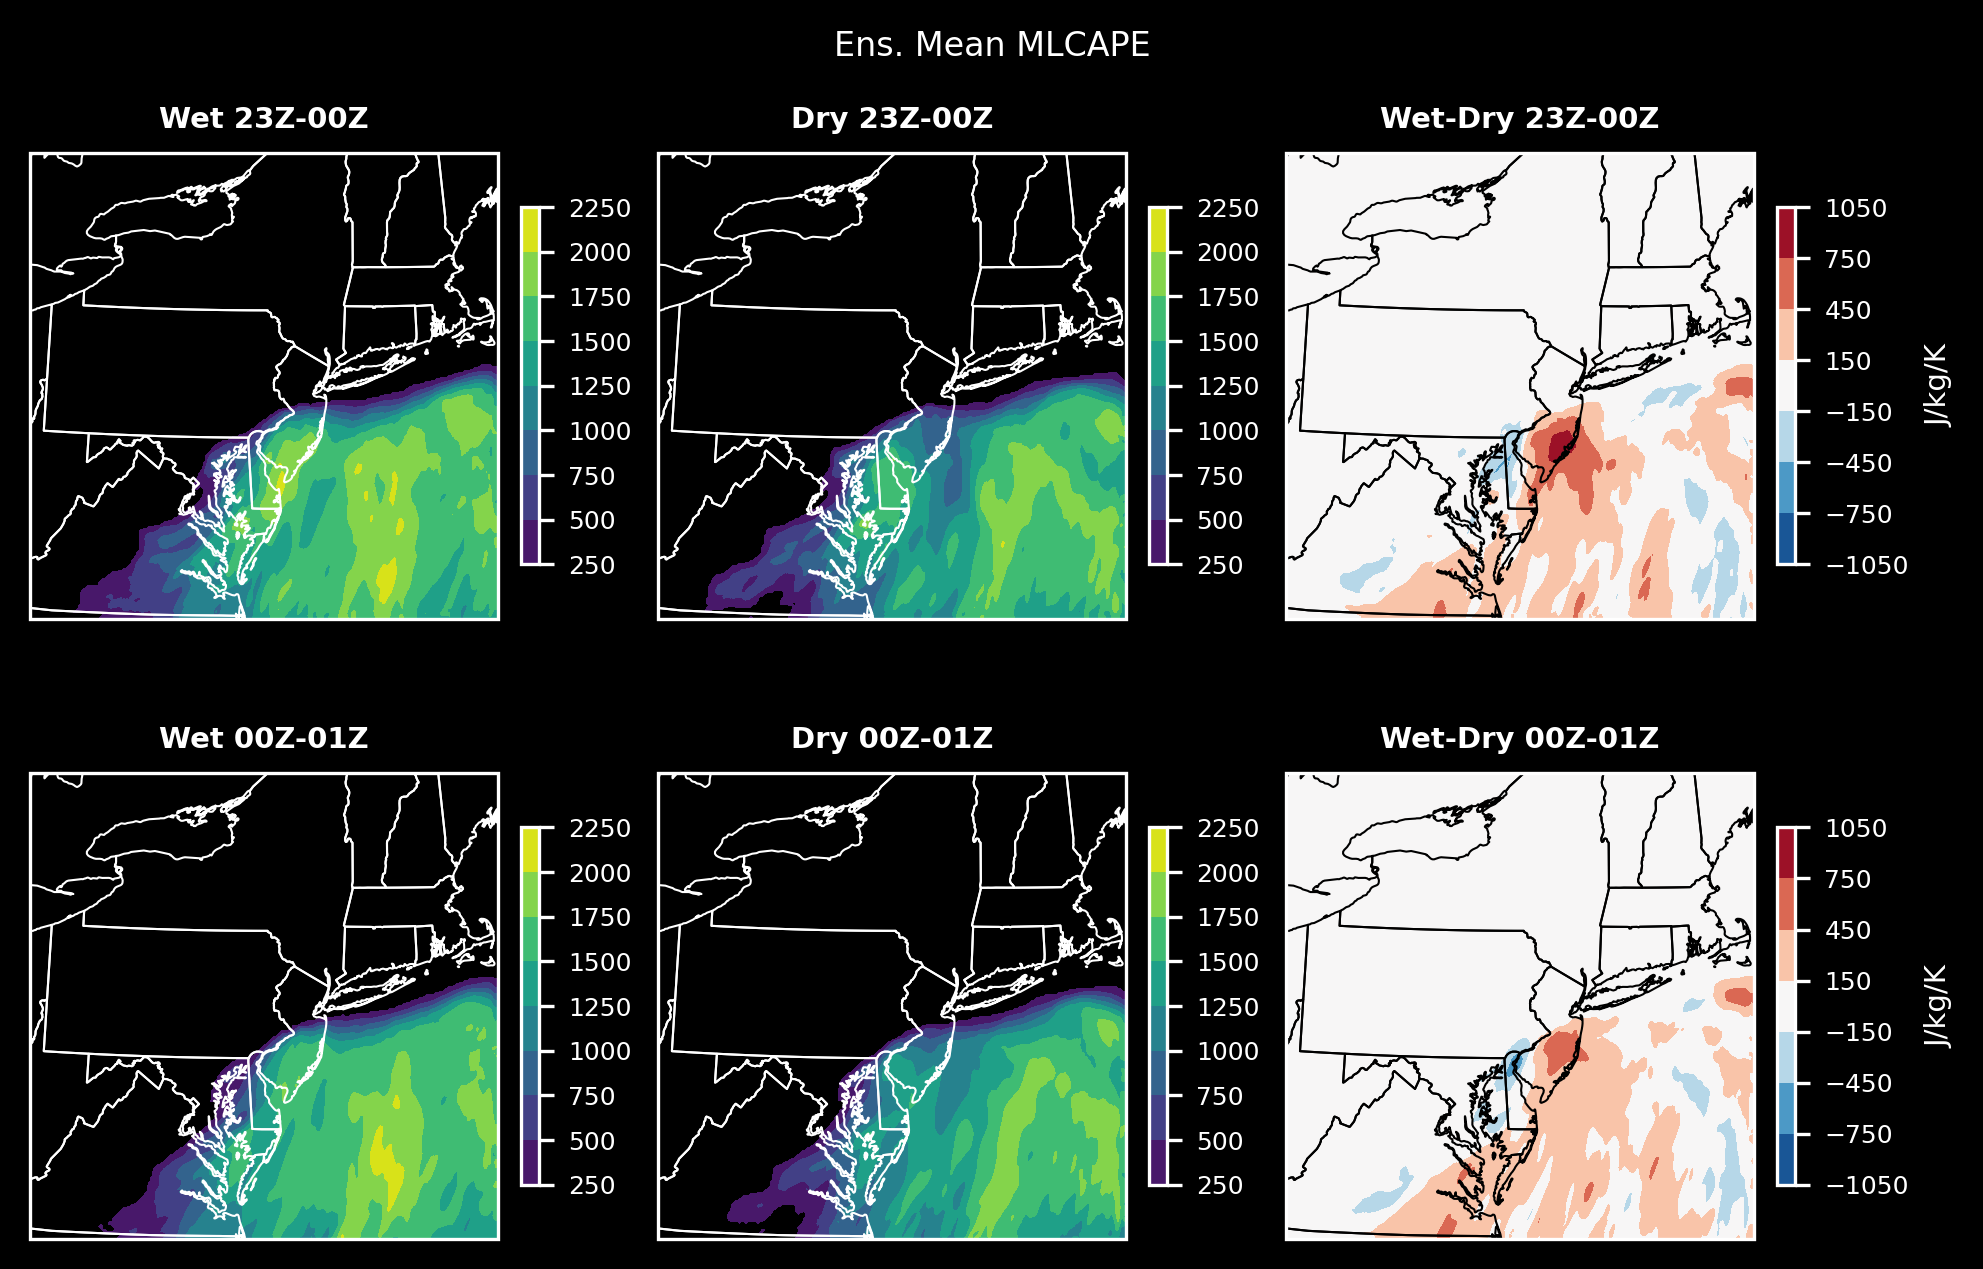

In [13]:
# Plot cape_hourly_wet, dry, and diff
titles = [
    "Wet 23Z-00Z",
    "Dry 23Z-00Z",
    "Wet-Dry 23Z-00Z",
    "Wet 00Z-01Z",
    "Dry 00Z-01Z",
    "Wet-Dry 00Z-01Z",
]

values = [
    cape_hourly_wet.sel(hour=23).mean(dim="run"),
    cape_hourly_dry.sel(hour=23).mean(dim="run"),
    cape_diff.sel(hour=23).mean(dim="run"),
    cape_hourly_wet.sel(hour=0).mean(dim="run"),
    cape_hourly_dry.sel(hour=0).mean(dim="run"),
    cape_diff.sel(hour=0).mean(dim="run"),
]

fig, axes = plt.subplots(
    2,
    3,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(6.5, 4.33),
)

for i, ax in enumerate(axes.flatten()):
    if i != 2 and i != 5:
        p = ax.contourf(
            lon,
            lat,
            values[i].where(values[i] > 250),
            transform=ccrs.PlateCarree(),
            levels=range(250, 2251, 250),
        )
        p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
    else:
        p = ax.contourf(
            lon,
            lat,
            values[i],
            transform=ccrs.PlateCarree(),
            levels=range(-1050, 1051, 300),
            cmap="RdBu_r",
        )
        p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

    cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    if(i in [2,5]):
        cbar.set_label("J/kg/K",fontsize=7)

    ax.set_title(titles[i],fontsize=7, fontweight="bold")

plt.suptitle("Ens. Mean MLCAPE",fontsize=8)
plt.show()

### PW

In [16]:
pw_hourly_wet = xr.concat(
    [fix_ne(e.pw.groupby(e.time.dt.hour).mean(dim="time")) for e in env_wet],  # type: ignore
    dim=init,
).stack(run=("ne", "init"))

pw_hourly_dry = xr.concat(
    [fix_ne(e.pw.groupby(e.time.dt.hour).mean(dim="time")) for e in env_dry],  # type: ignore
    dim=init,
).stack(run=("ne", "init"))

pw_diff = pw_hourly_wet - pw_hourly_dry

In [36]:
# Take the time mean of the precipitable water

pw_23to00_all = xr.concat([time_mean(e.pw,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00") for e in env],dim=init).stack(
                            run=("ne","init")).chunk({"run":-1})
pw_00to01_all = xr.concat([time_mean(e.pw,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00") for e in env],dim=init).stack(
                            run=("ne","init")).chunk({"run":-1})
pw_23to00_wet = xr.concat([fix_ne(time_mean(e.pw,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00")) for e in env_wet],dim=init).stack(
                            run=("ne","init"))
pw_00to01_wet = xr.concat([fix_ne(time_mean(e.pw,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00")) for e in env_wet],dim=init).stack(
                            run=("ne","init"))
pw_23to00_dry = xr.concat([fix_ne(time_mean(e.pw,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00")) for e in env_dry],dim=init).stack(
                            run=("ne","init"))
pw_00to01_dry = xr.concat([fix_ne(time_mean(e.pw,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00")) for e in env_dry],dim=init).stack(
                            run=("ne","init"))
    
# Bootstrap!

with ProgressBar():
    set1_23to00 = resample_iterations_idx(
        pw_23to00_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set2_23to00 = resample_iterations_idx(
        pw_23to00_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set1_00to01 = resample_iterations_idx(
        pw_00to01_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set2_00to01 = resample_iterations_idx(
        pw_00to01_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    

[########################################] | 100% Completed | 56.39 ss
[########################################] | 100% Completed | 60.14 ss
[########################################] | 100% Completed | 49.65 ss
[########################################] | 100% Completed | 51.40 ss


In [40]:
# Calculate the mean difference and create bootstrap sample for comparison
pw_diff_23to00 = (pw_23to00_wet - pw_23to00_dry).mean(dim="run")
pw_diff_00to01 = (pw_00to01_wet - pw_00to01_dry).mean(dim="run")
pw_boot_23to00 = set1_23to00 - set2_23to00
pw_boot_00to01 = set1_00to01 - set2_00to01

# # Create mask for hatching on plot
pw_mask_23to00 = (((pw_diff_23to00 > pw_boot_23to00.quantile(0.95,dim="iteration"))|
                   (pw_diff_23to00 < pw_boot_23to00.quantile(0.05,dim="iteration")))&
                   (np.fabs(pw_diff_23to00) > 0.03))
pw_mask_00to01 = (((pw_diff_00to01 > pw_boot_00to01.quantile(0.95,dim="iteration"))|
                   (pw_diff_00to01 < pw_boot_00to01.quantile(0.05,dim="iteration")))&
                   (np.fabs(pw_diff_00to01) > 0.03))

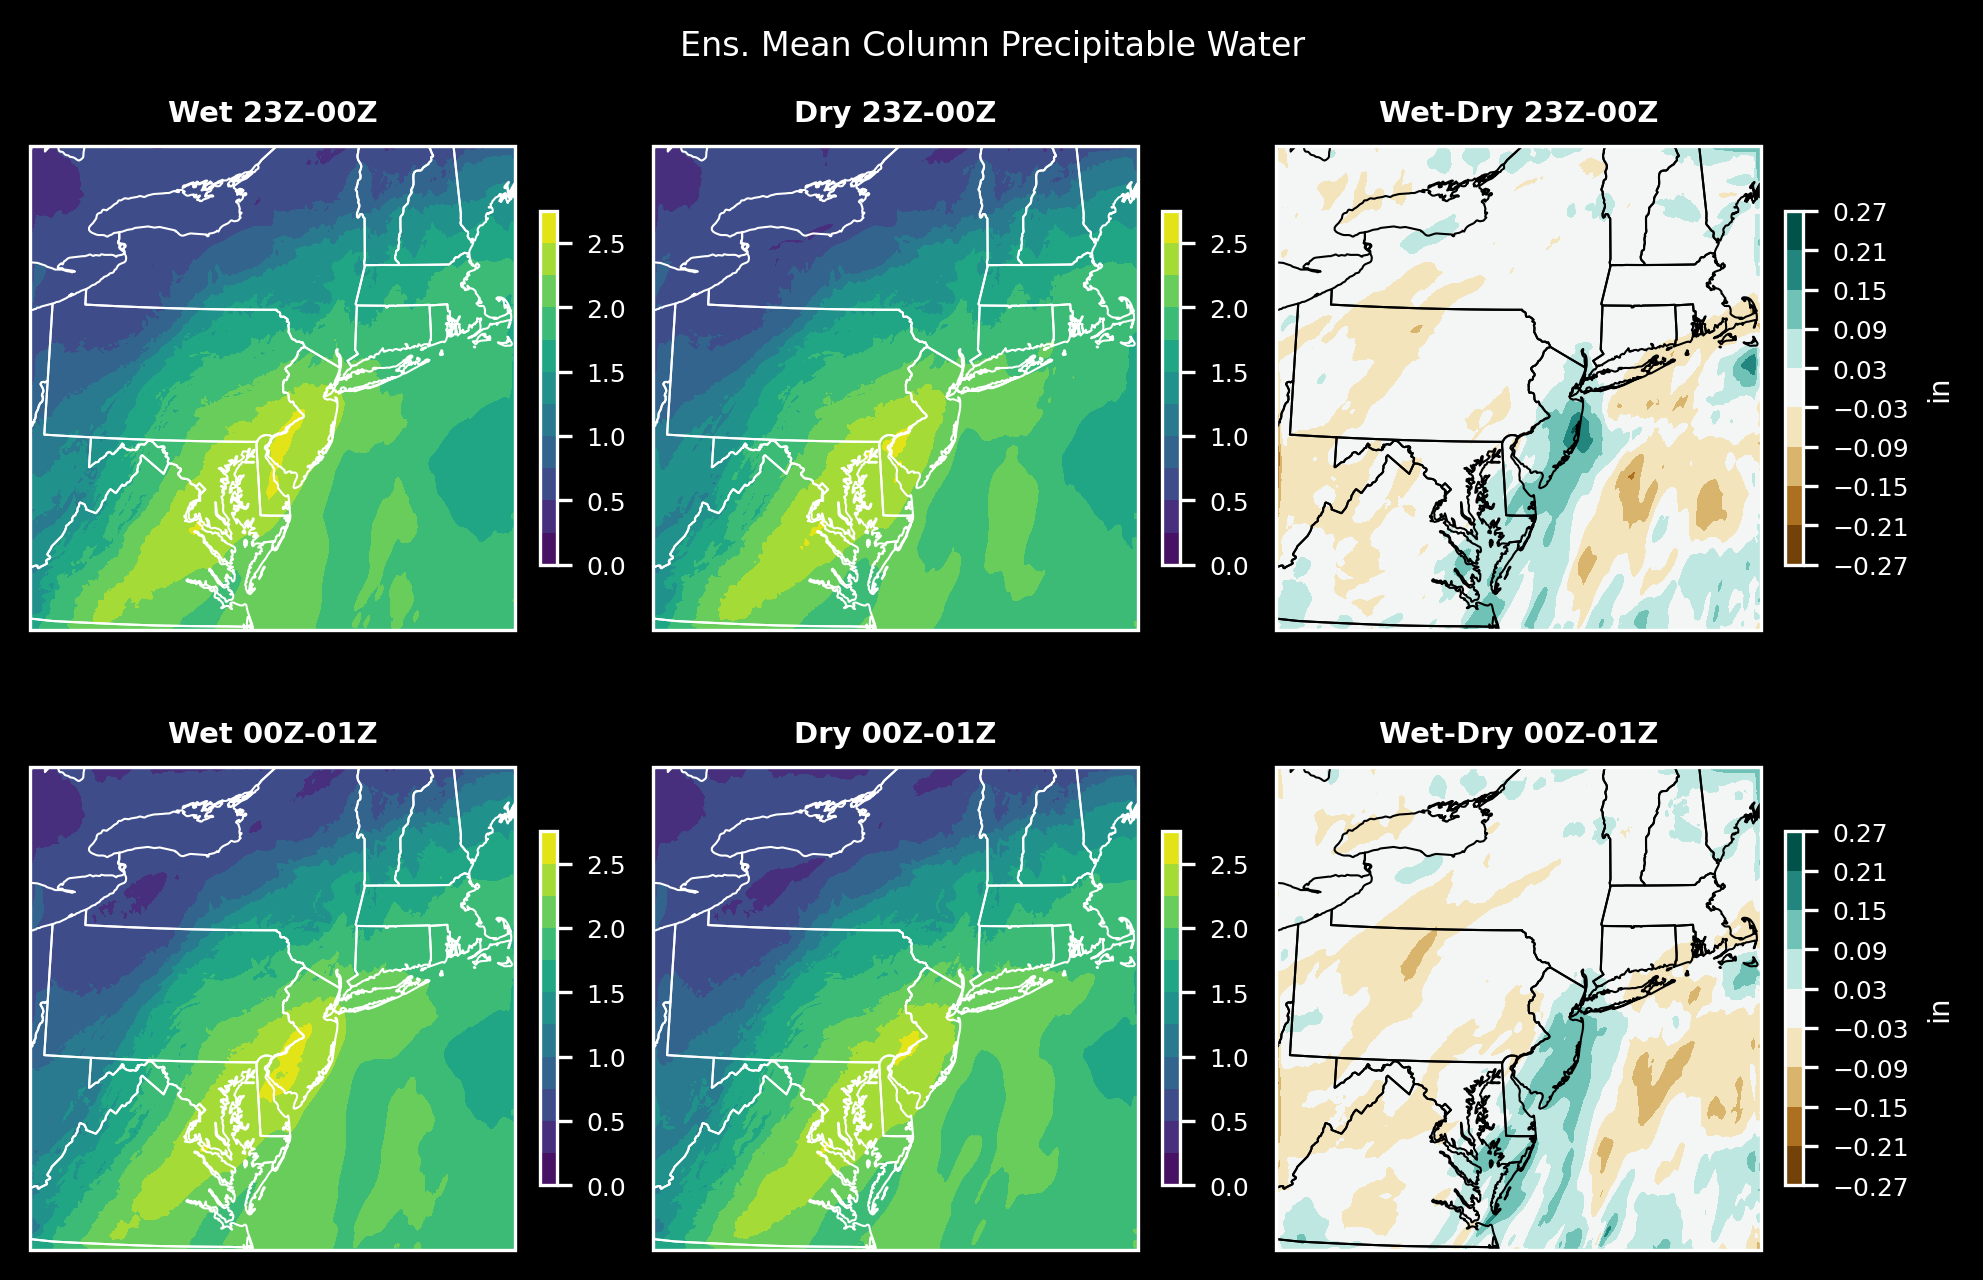

In [17]:
# Plot pw_hourly_wet, dry, and diff
titles = [
    "Wet 23Z-00Z",
    "Dry 23Z-00Z",
    "Wet-Dry 23Z-00Z",
    "Wet 00Z-01Z",
    "Dry 00Z-01Z",
    "Wet-Dry 00Z-01Z",
]

values = [
    pw_hourly_wet.sel(hour=23).mean(dim="run"),
    pw_hourly_dry.sel(hour=23).mean(dim="run"),
    pw_diff.sel(hour=23).mean(dim="run"),
    pw_hourly_wet.sel(hour=0).mean(dim="run"),
    pw_hourly_dry.sel(hour=0).mean(dim="run"),
    pw_diff.sel(hour=0).mean(dim="run"),
]

fig, axes = plt.subplots(
    2,
    3,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(6.5, 4.33),
)

for i, ax in enumerate(axes.flatten()):
    if i != 2 and i != 5:
        p = ax.contourf(
            lon,
            lat,
            values[i],
            cmap="viridis",
            transform=ccrs.PlateCarree(),
            levels=np.arange(0,2.76,0.25),
        )
        p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
    else:
        p = ax.contourf(
            lon,
            lat,
            values[i],
            transform=ccrs.PlateCarree(),
            levels=np.arange(-0.27,0.28,0.06),
            cmap="BrBG",
        )
        p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

    cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    if(i in [2,5]):
        cbar.set_label("in",fontsize=7)

    ax.set_title(titles[i],fontsize=7, fontweight="bold")

plt.suptitle("Ens. Mean Column Precipitable Water",fontsize=8)
plt.show()

## PMM

### Functions

In [11]:
def process_dim(da):
    """Helper function to process DataArray with or without time dimension"""
    ens_mean = da.mean(dim="run").stack(i=("lat", "lon"))
    sorted_mean = ens_mean.sortby(ens_mean)
    sorted_all = np.sort(da.values.flatten())[:: len(da.run)]
    sorted_mean.values = sorted_all
    return sorted_mean.unstack("i")


def pmm(da: xr.DataArray) -> xr.DataArray:
    """Compute the probability matched mean of a DataArray"""
    if "time" in da.dims:
        results = []
        for time_slice in da.time:
            time_da = da.sel(time=time_slice)
            results.append(process_dim(time_da))
        return xr.concat(results, dim="time")
    else:
        return process_dim(da)


@delayed
def bootstrap_iteration(da, sample_size):
    """Single iteration of bootstrapping"""
    # Sample without replacement
    sample1 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))
    sample2 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))

    # Compute PMM for each sample
    pmm1 = pmm(sample1)
    pmm2 = pmm(sample2)

    # Compute difference of PMMs
    diff = pmm1 - pmm2
    return diff


def bootstrap_pmm_difference(
    da: xr.DataArray, sample_size: int, iterations: int
) -> xr.DataArray:
    """Perform bootstrapping and compute differences of PMM"""
    tasks = [bootstrap_iteration(da, sample_size) for _ in range(iterations)]
    results = compute(*tasks)
    return xr.concat(results, dim="iteration")

# Get the maximum 5-minute UH in the period 01-02 UTC
def get_max_uh(da: xr.DataArray) -> xr.DataArray:
    return da.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")).max(
        dim="time"
    )

### Relative vorticity

In [33]:
# I feel like it would be odd to take the time mean of reflectivity, so let's
# instead just pick certain times.
times = [
    "2021-09-01 23:30:00",
    "2021-09-02 00:00:00",
    "2021-09-02 00:30:00",
    "2021-09-02 01:00:00",
    "2021-09-02 01:30:00",
    "2021-09-02 02:00:00",
]

rv_wet = (
    xr.concat(
        [
            xr.concat([fix_ne(r) for r in rel_vort_wet], dim=init).sel(time=t)
            for t in times
        ],
        dim="time",
    )
    .stack(run=("ne", "init"))
    .fillna(0)
    .apply(gaussian_filter, sigma=4, axes=(1, 2))
    .REL_VORT
)
rv_dry = (
    xr.concat(
        [
            xr.concat([fix_ne(r) for r in rel_vort_dry], dim=init).sel(time=t)
            for t in times
        ],
        dim="time",
    )
    .stack(run=("ne", "init"))
    .fillna(0)
    .apply(gaussian_filter, sigma=4, axes=(1, 2))
    .REL_VORT
)

rv_diff = rv_wet - rv_dry

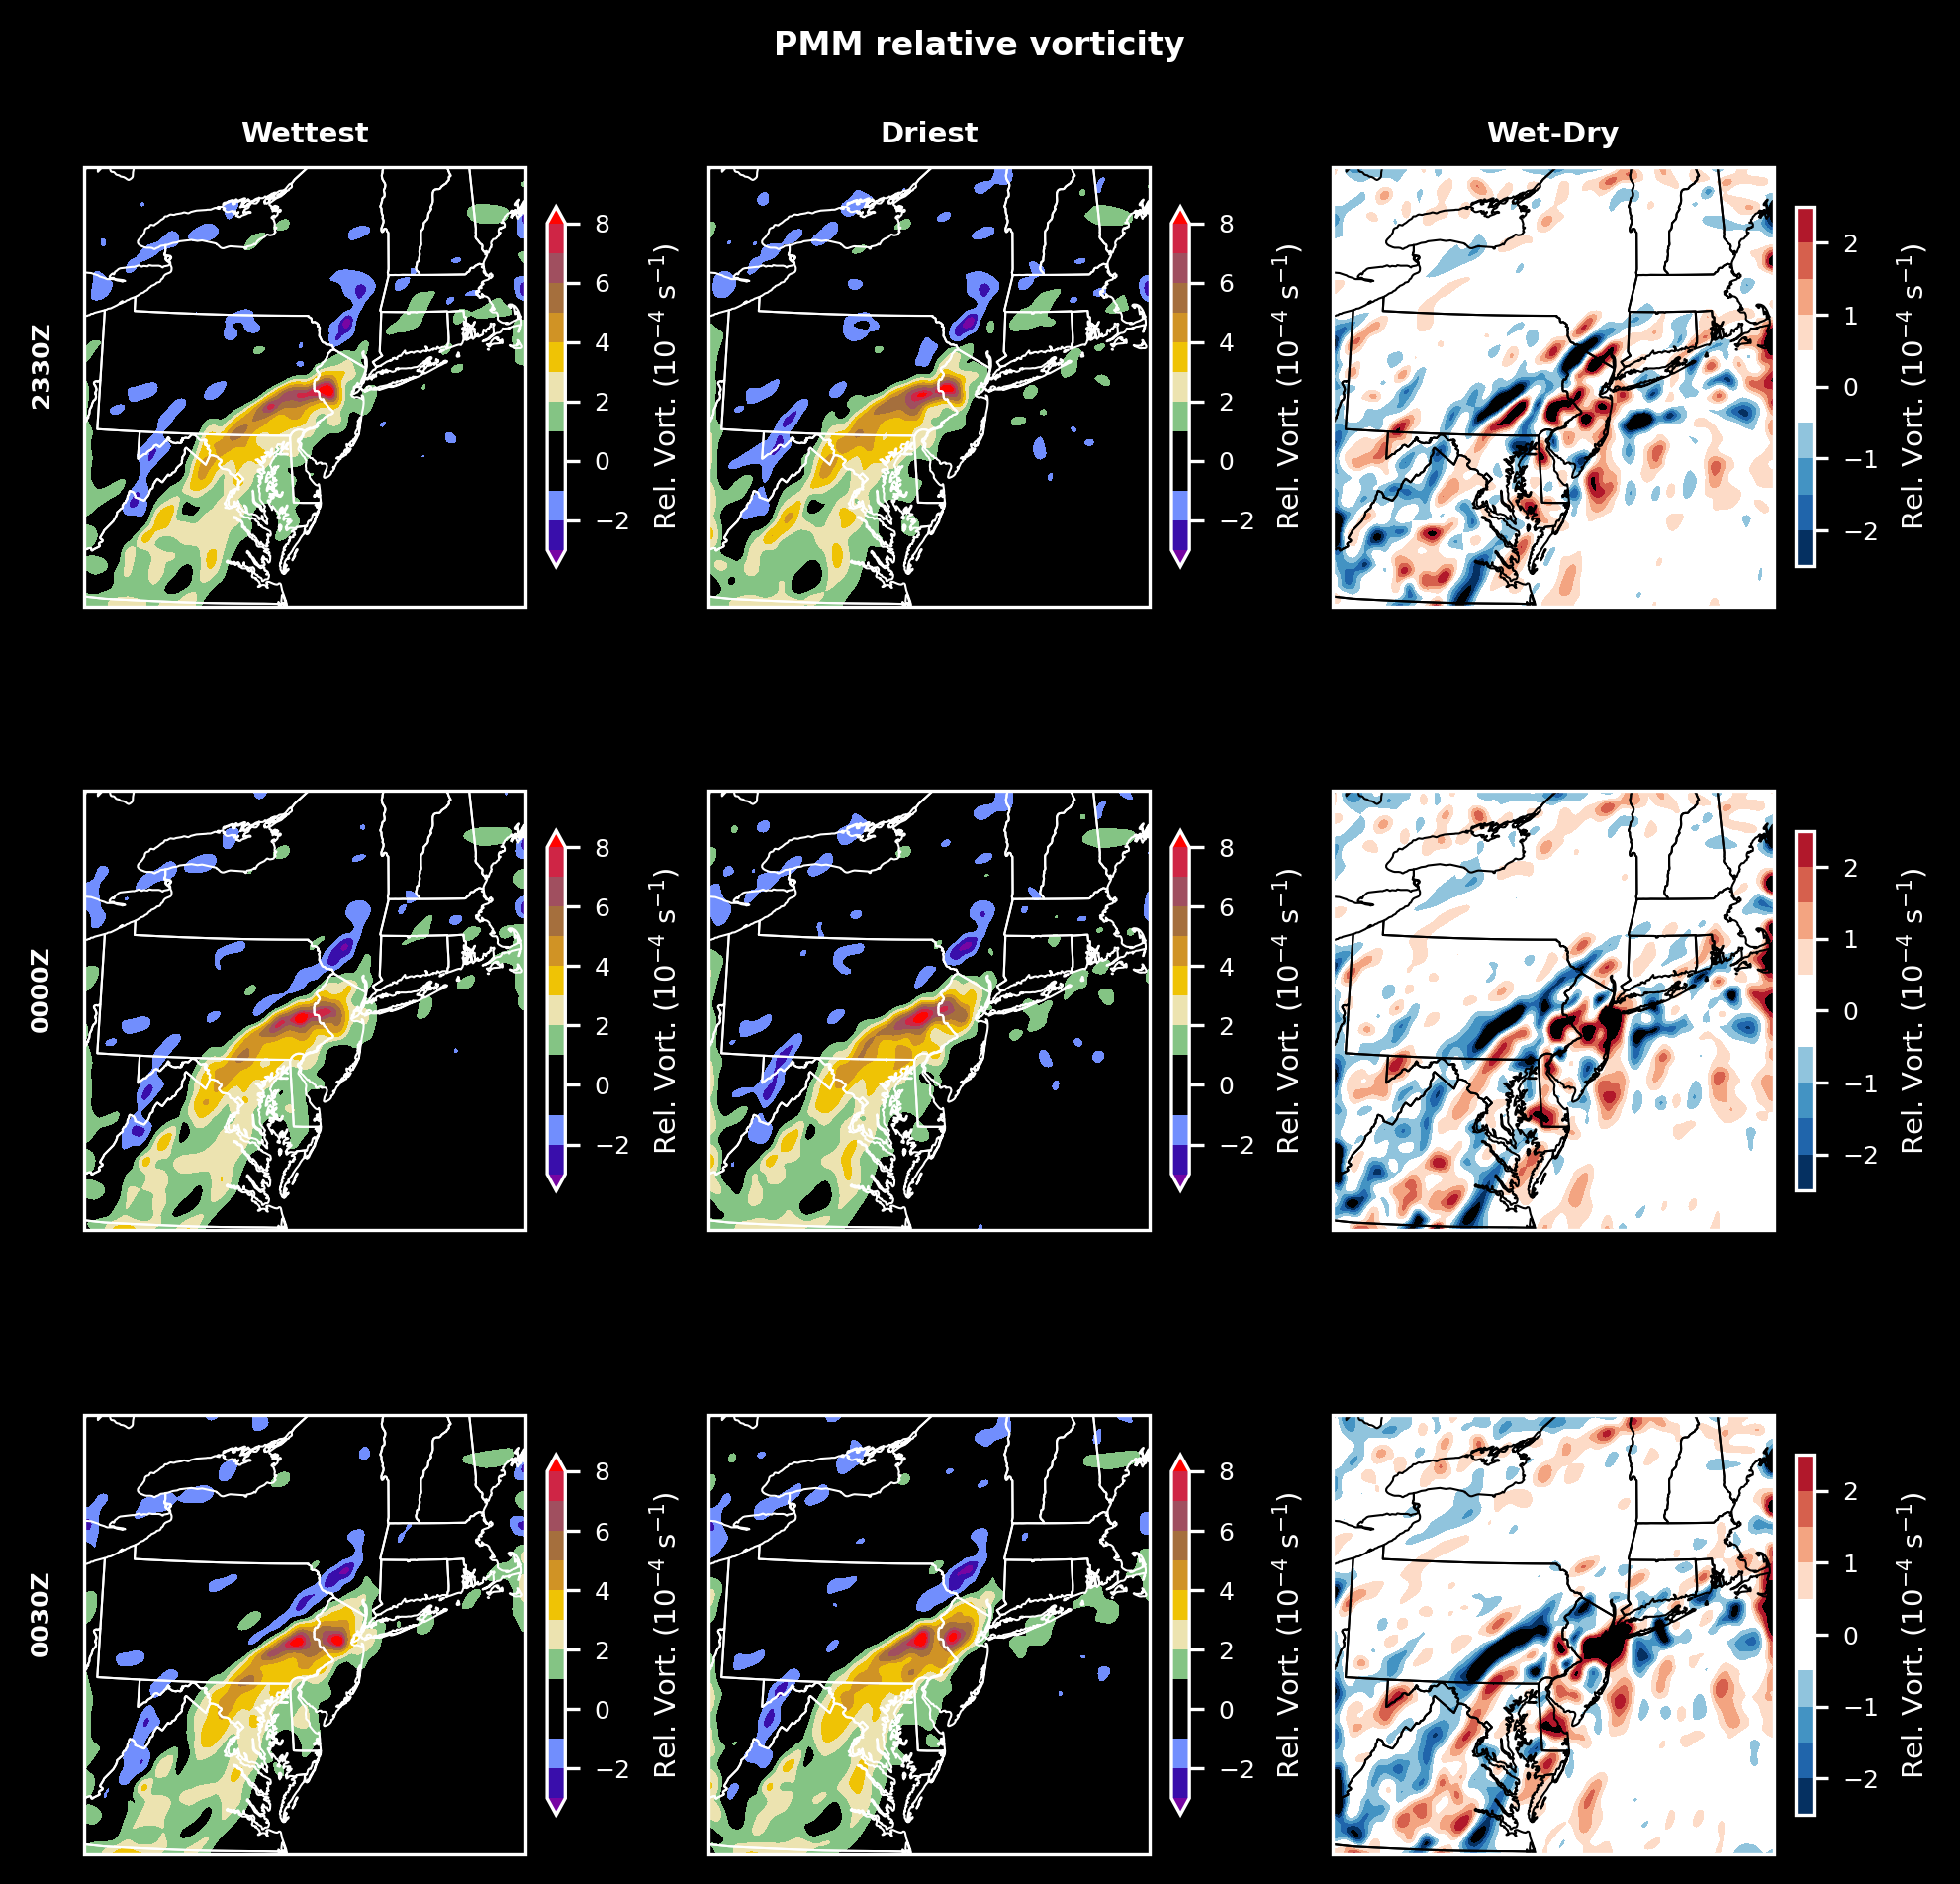

In [34]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

ctable = ctables.registry.get_colortable("Carbone42")
colors = ctable(np.linspace(0,1,13,endpoint=True))
colors[3]=None
colors[4]=None

colors_diff = plt.get_cmap("RdBu_r")(np.linspace(0,1,11))
colors_diff[4]=(1,1,1,1)
colors_diff[5]=(1,1,1,1)

plt.style.use("dark_background")

linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
z = []
for t in range(0,3,1):
    for rv in [rv_wet,rv_dry,rv_diff]:
        z.append(rv.isel(time=t).sel(pres=85000)*1e4)

fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6.5,6.5),sharey=True)

for i,ax in enumerate(axes.flatten()):
    if(i%3 != 2):
        p = ax.contourf(lon,lat,pmm(z[i]),
                        colors=colors,extend="both",
                        transform=ccrs.PlateCarree(),levels=np.arange(-3,8.1,1)
                        )
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
        cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    else:
        p = ax.contourf(lon,lat,pmm(z[i]),
                        transform=ccrs.PlateCarree(),
                        colors=colors_diff,levels=np.arange(-2.5,2.6,0.5)
                        )
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="black")
        cbar = plt.colorbar(p,ax=ax,shrink=0.6#,ticks=range(-22,23,4)
        )

    cbar.ax.tick_params(labelsize=6)
    cbar.set_label("Rel. Vort. (10$^{-4}$ s$^{-1}$)",fontsize=7)

    if(i<=2):
        ax.set_title(titles[i],fontsize=7, fontweight="bold")

axes[0,0].text(-0.07,0.55,"2330Z",transform=axes[0,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")
axes[1,0].text(-0.07,0.55,"0000Z",transform=axes[1,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")
axes[2,0].text(-0.07,0.55,"0030Z",transform=axes[2,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")


plt.suptitle("PMM 850 hPa relative vorticity",fontsize=8,fontweight="bold")

plt.show()

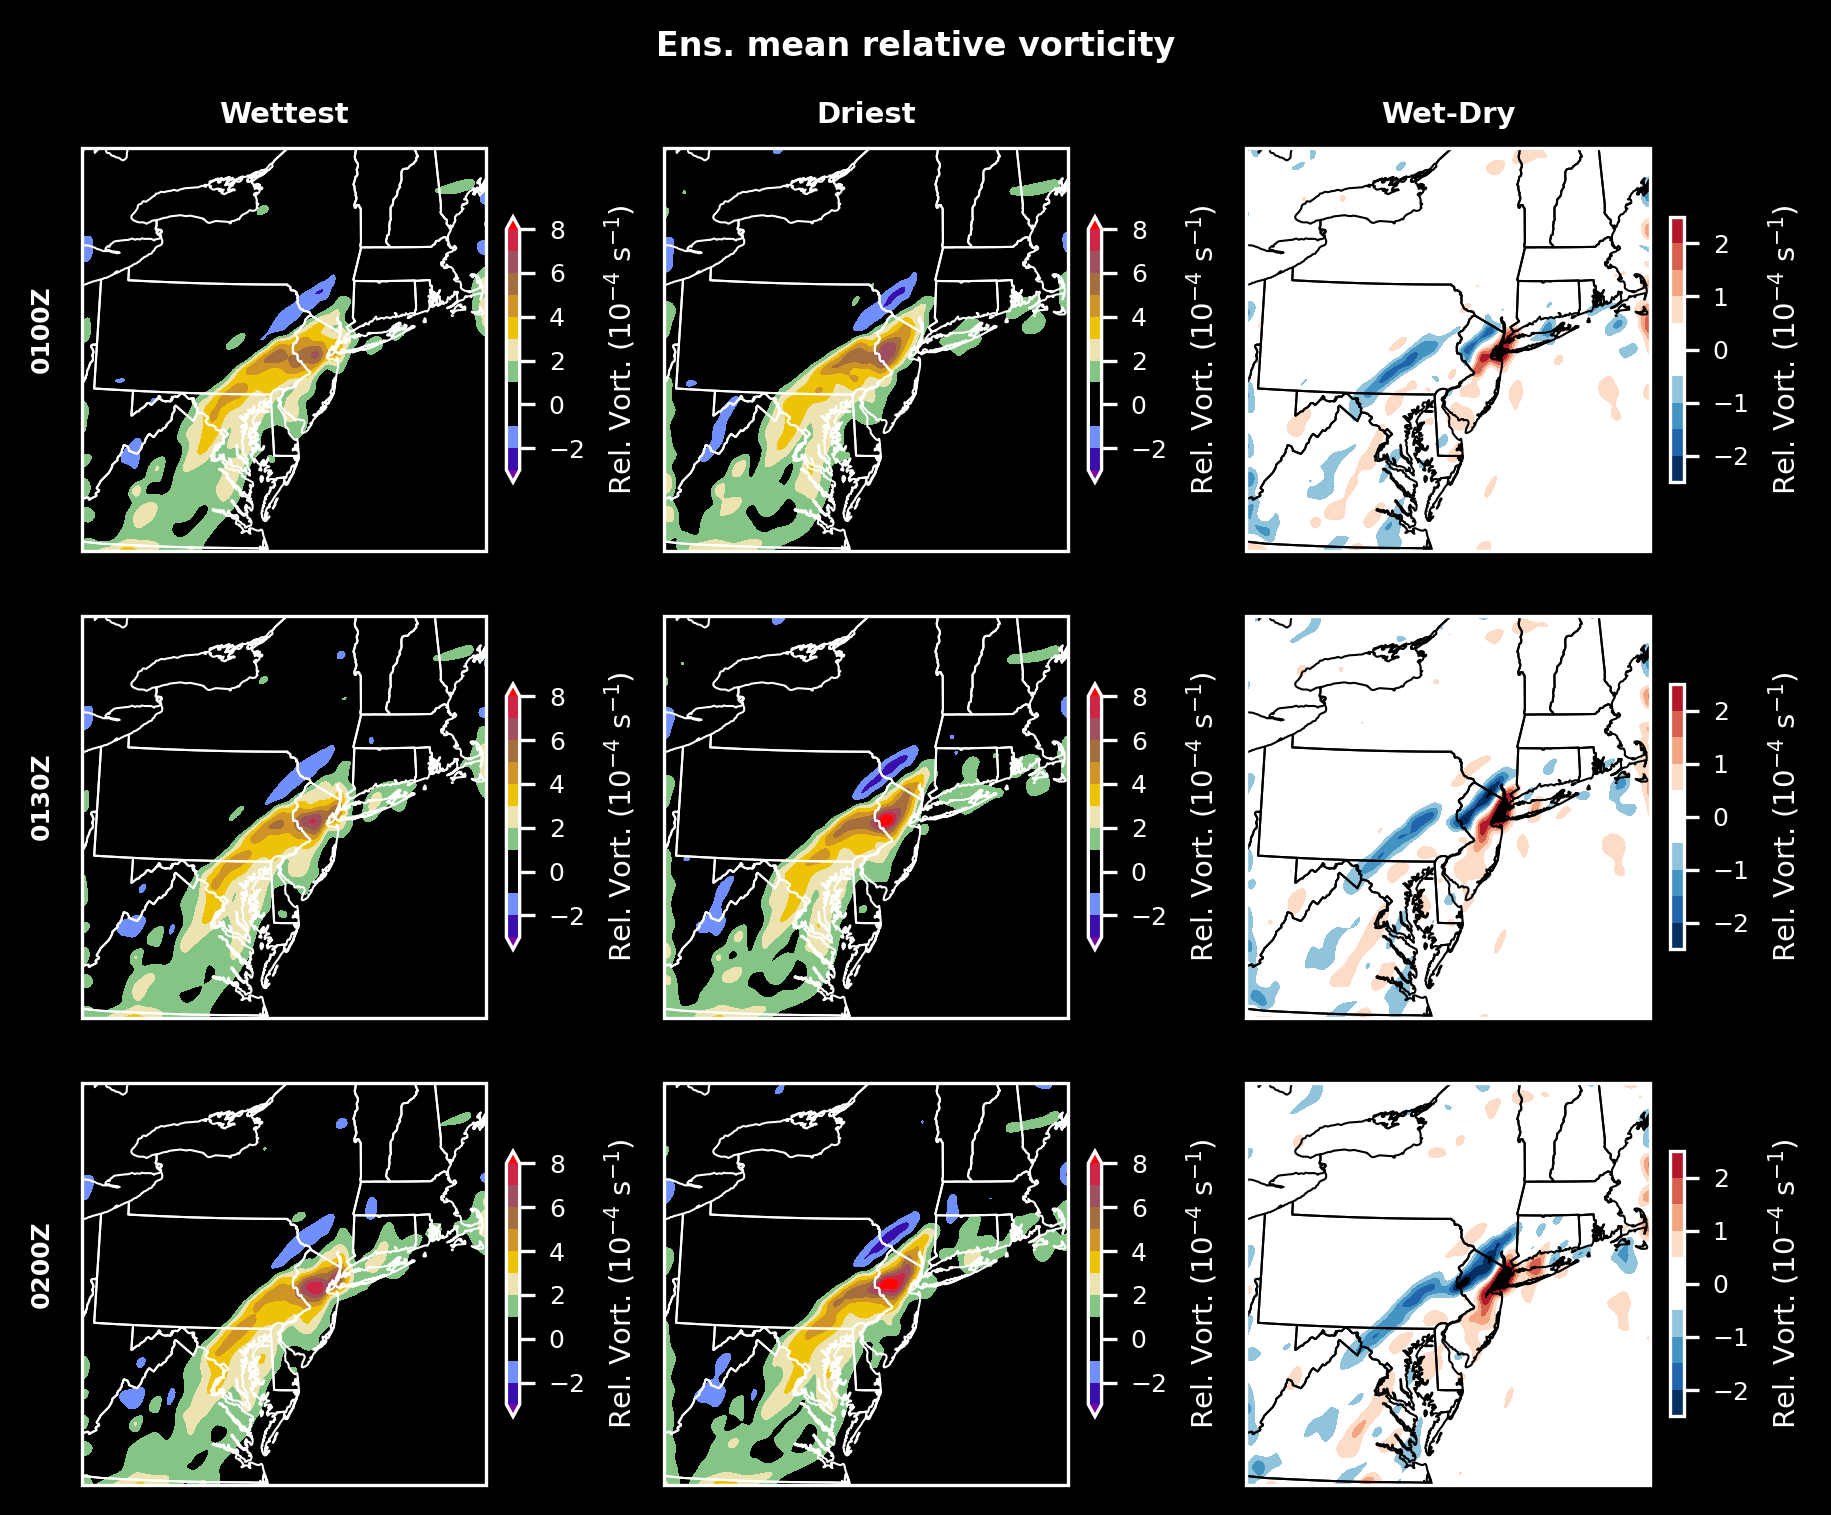

In [11]:
linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
z = []
for t in range(3,6,1):
    for rv in [rv_wet,rv_dry,rv_diff]:
        z.append(rv.REL_VORT.isel(time=t).sel(pres=85000)*1e4)
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,5),sharey=True)

for i,ax in enumerate(axes.flatten()):
    if(i%3 != 2):
        p = ax.contourf(lon,lat,z[i].mean(dim="run"),
                        colors=colors,extend="both",
                        transform=ccrs.PlateCarree(),levels=np.arange(-3,8.1,1)
                        )
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
        cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    else:
        p = ax.contourf(lon,lat,z[i].mean(dim="run"),
                        transform=ccrs.PlateCarree(),
                        colors=colors_diff,levels=np.arange(-2.5,2.6,0.5)
                        )
        # m = ax.contourf(lon,lat,dbz_mask.isel(time=i//3),colors="none",levels=[0.5,1.5],
        #                 hatches=["////////",""],transform=ccrs.PlateCarree())
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="black")
        cbar = plt.colorbar(p,ax=ax,shrink=0.6#,ticks=range(-22,23,4)
        )

    cbar.ax.tick_params(labelsize=6)
    cbar.set_label("Rel. Vort. (10$^{-4}$ s$^{-1}$)",fontsize=7)

    if(i<=2):
        ax.set_title(titles[i],fontsize=7, fontweight="bold")

axes[0,0].text(-0.07,0.55,"0100Z",transform=axes[0,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")
axes[1,0].text(-0.07,0.55,"0130Z",transform=axes[1,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")
axes[2,0].text(-0.07,0.55,"0200Z",transform=axes[2,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")


plt.suptitle("Ens. mean relative vorticity",fontsize=8,fontweight="bold")

plt.show()

In [12]:
# Make a map of the positions of the relative vorticity centers

inds_wet = rv_wet.REL_VORT.mean(dim="run").sel(pres=85000).argmax(dim=["lat","lon"])
NY_wet,NX_wet = inds_wet["lat"],inds_wet["lon"]

inds_dry = rv_dry.REL_VORT.mean(dim="run").sel(pres=85000).argmax(dim=["lat","lon"])
NY_dry,NX_dry = inds_wet["lat"],inds_wet["lon"]

lats_wet = []
lons_wet = []
for t in range(len(NY_wet)):
    lats_wet.append(lat.isel(NY=int(NY_wet[t]),NX=int(NX_wet[t])))
    lons_wet.append(lon.isel(NY=int(NY_wet[t]),NX=int(NX_wet[t])))

In [13]:
inds_wet = rv_wet.REL_VORT.mean(dim="run").sel(pres=85000).argmax(dim=["lat","lon"])
lats_wet = rv_wet.XLAT.mean(dim="run").isel(lat=inds_wet["lat"],lon=inds_wet["lon"])
lons_wet = rv_wet.XLONG.mean(dim="run").isel(lat=inds_wet["lat"],lon=inds_wet["lon"])

inds_dry = rv_dry.REL_VORT.mean(dim="run").sel(pres=85000).argmax(dim=["lat","lon"])
lats_dry = rv_dry.XLAT.mean(dim="run").isel(lat=inds_dry["lat"],lon=inds_dry["lon"])
lons_dry = rv_dry.XLONG.mean(dim="run").isel(lat=inds_dry["lat"],lon=inds_dry["lon"])

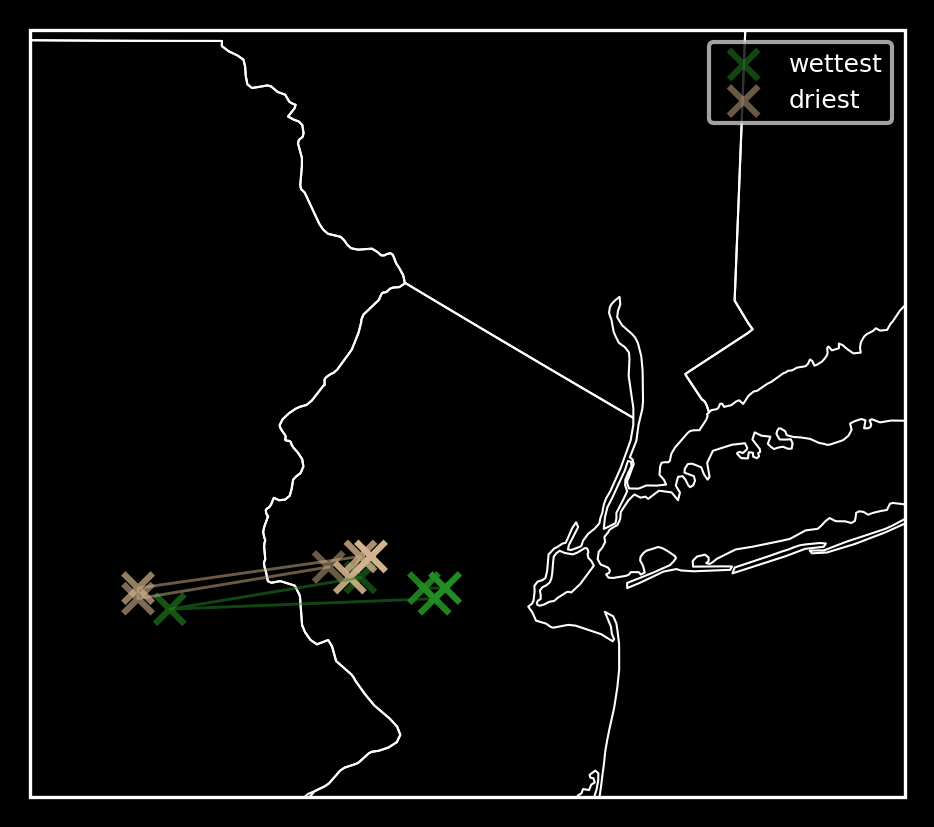

In [14]:
plt.style.use("dark_background")

linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()
alphas = np.linspace(0.5,1,6,endpoint=True)

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj),dpi=300,
                       layout="constrained",figsize=(3,3),sharey=True)

ax.contourf(lon,lat,rv_wet.REL_VORT.mean(dim="run").sel(pres=85000).isel(time=0),
            transform=ccrs.PlateCarree(),colors="none")
ax.scatter(lons_wet,lats_wet,transform=ccrs.PlateCarree(),s=50,color="forestgreen",
marker="x",alpha=alphas,label="wettest")
ax.plot(lons_wet,lats_wet,transform=ccrs.PlateCarree(),color="forestgreen",alpha=0.5,
linewidth=0.7)
ax.scatter(lons_dry,lats_dry,transform=ccrs.PlateCarree(),s=50,color="tan",
marker="x",alpha=alphas,label="driest")
ax.plot(lons_dry,lats_dry,transform=ccrs.PlateCarree(),color="tan",alpha=0.5,
linewidth=0.7)

ax.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
ax.set_extent([-76,-73,40,42])
ax.legend(loc="best",fontsize=6)


plt.show()
                

### Reflectivity

In [12]:
# I feel like it would be odd to take the time mean of reflectivity, so let's
# instead just pick certain times.
times = ["2021-09-01 23:30:00",
         "2021-09-02 00:00:00",
         "2021-09-02 00:30:00",
         "2021-09-02 01:00:00",
         "2021-09-02 01:30:00",
         "2021-09-02 02:00:00"]

dbz_all = xr.concat(
    [e.comp_dz for e in ens],dim=init
    ).stack(run=("ne","init")).chunk({"run":-1})
dbz_wet = xr.concat([xr.concat([fix_ne(e.comp_dz) for e in ens_wet],dim=init).sel(time=t)
           for t in times],dim="time").stack(run=("ne","init"))
dbz_dry = xr.concat([xr.concat([fix_ne(e.comp_dz) for e in ens_dry],dim=init).sel(time=t)
           for t in times],dim="time").stack(run=("ne","init"))


# Bootstrap!

# with ProgressBar():
#     set1_list = []
#     set2_list = []
#     for t in times:
#         set1_list.append(resample_iterations_idx(
#             dbz_all.sel(time=t).squeeze(),1000,dim="run",replace=False,dim_max=20
#             ).mean(dim="run").chunk({"lon":30}).compute())
#         set2_list.append(resample_iterations_idx(
#             dbz_all.sel(time=t).squeeze(),1000,dim="run",replace=False,dim_max=20
#             ).mean(dim="run").chunk({"lon":30}).compute())
        
# set1 = xr.concat(set1_list,dim="time")
# set2 = xr.concat(set2_list,dim="time")
    

In [63]:
data_array = xr.concat([dbz_all.sel(time=t) for t in times],dim="time").squeeze()

# Using Dask for parallel delayed computations
from dask import delayed, compute

def select_and_pmm(da, runs=20):
    random_indices = np.random.choice(da.run.values, size=runs, replace=False)
    selected_data = da.sel(run=random_indices)
    return pmm(selected_data)

# Number of iterations
iterations = 100

results_list = [delayed(select_and_pmm)(data_array) for _ in range(iterations)]
delayed_results = delayed(xr.concat)(results_list, dim='iteration')
results = delayed_results.compute()

# Assign coordinate values to the new dimension
results = results.assign_coords(iteration=np.arange(iterations))

# Now results should have dimensions (iteration, lat, lon)
print(results)

# To-do next: iterate through time dimension

ValueError: Input DataArray is not 1-D.

In [59]:
data_array

<xarray.DataArray 'comp_dz' (time: 6, lat: 300, lon: 300, run: 72)> Size: 156MB
dask.array<concatenate, shape=(6, 300, 300, 72), dtype=float32, chunksize=(1, 300, 300, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 48B 2021-09-01 23:30:00 ... 2021-09-02 02:00:00
  * lat      (lat) int64 2kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * lon      (lon) int64 2kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * run      (run) object 576B MultiIndex
  * ne       (run) int64 576B 0 0 0 0 1 1 1 1 2 2 ... 15 16 16 16 16 17 17 17 17
  * init     (run) <U3 864B '20Z' '21Z' '22Z' '23Z' ... '20Z' '21Z' '22Z' '23Z'
Attributes:
    long_name:      Composite Reflectivity
    units:          dBZ
    level:          Z0
    init_time:      20210901_200000
    valid_time:     20210901_200000
    init_time_ut:   1630544400
    valid_time_ut:  1630544400

In [29]:
# Calculate the mean difference and create bootstrap sample for comparison
# dbz_diff = (dbz_wet - dbz_dry).mean(dim="run")
dbz_diff = xr.concat([
    pmm(dbz_wet.sel(time=t).squeeze()) - pmm(dbz_dry.sel(time=t).squeeze())
    for t in times
    ],dim="time")
# dbz_boot = set1 - set2

# # Create mask for hatching on plot
# dbz_mask = (((dbz_diff > dbz_boot.quantile(0.95,dim="iteration"))|
#                    (dbz_diff < dbz_boot.quantile(0.05,dim="iteration")))&
#                    (np.fabs(dbz_diff) > 2))

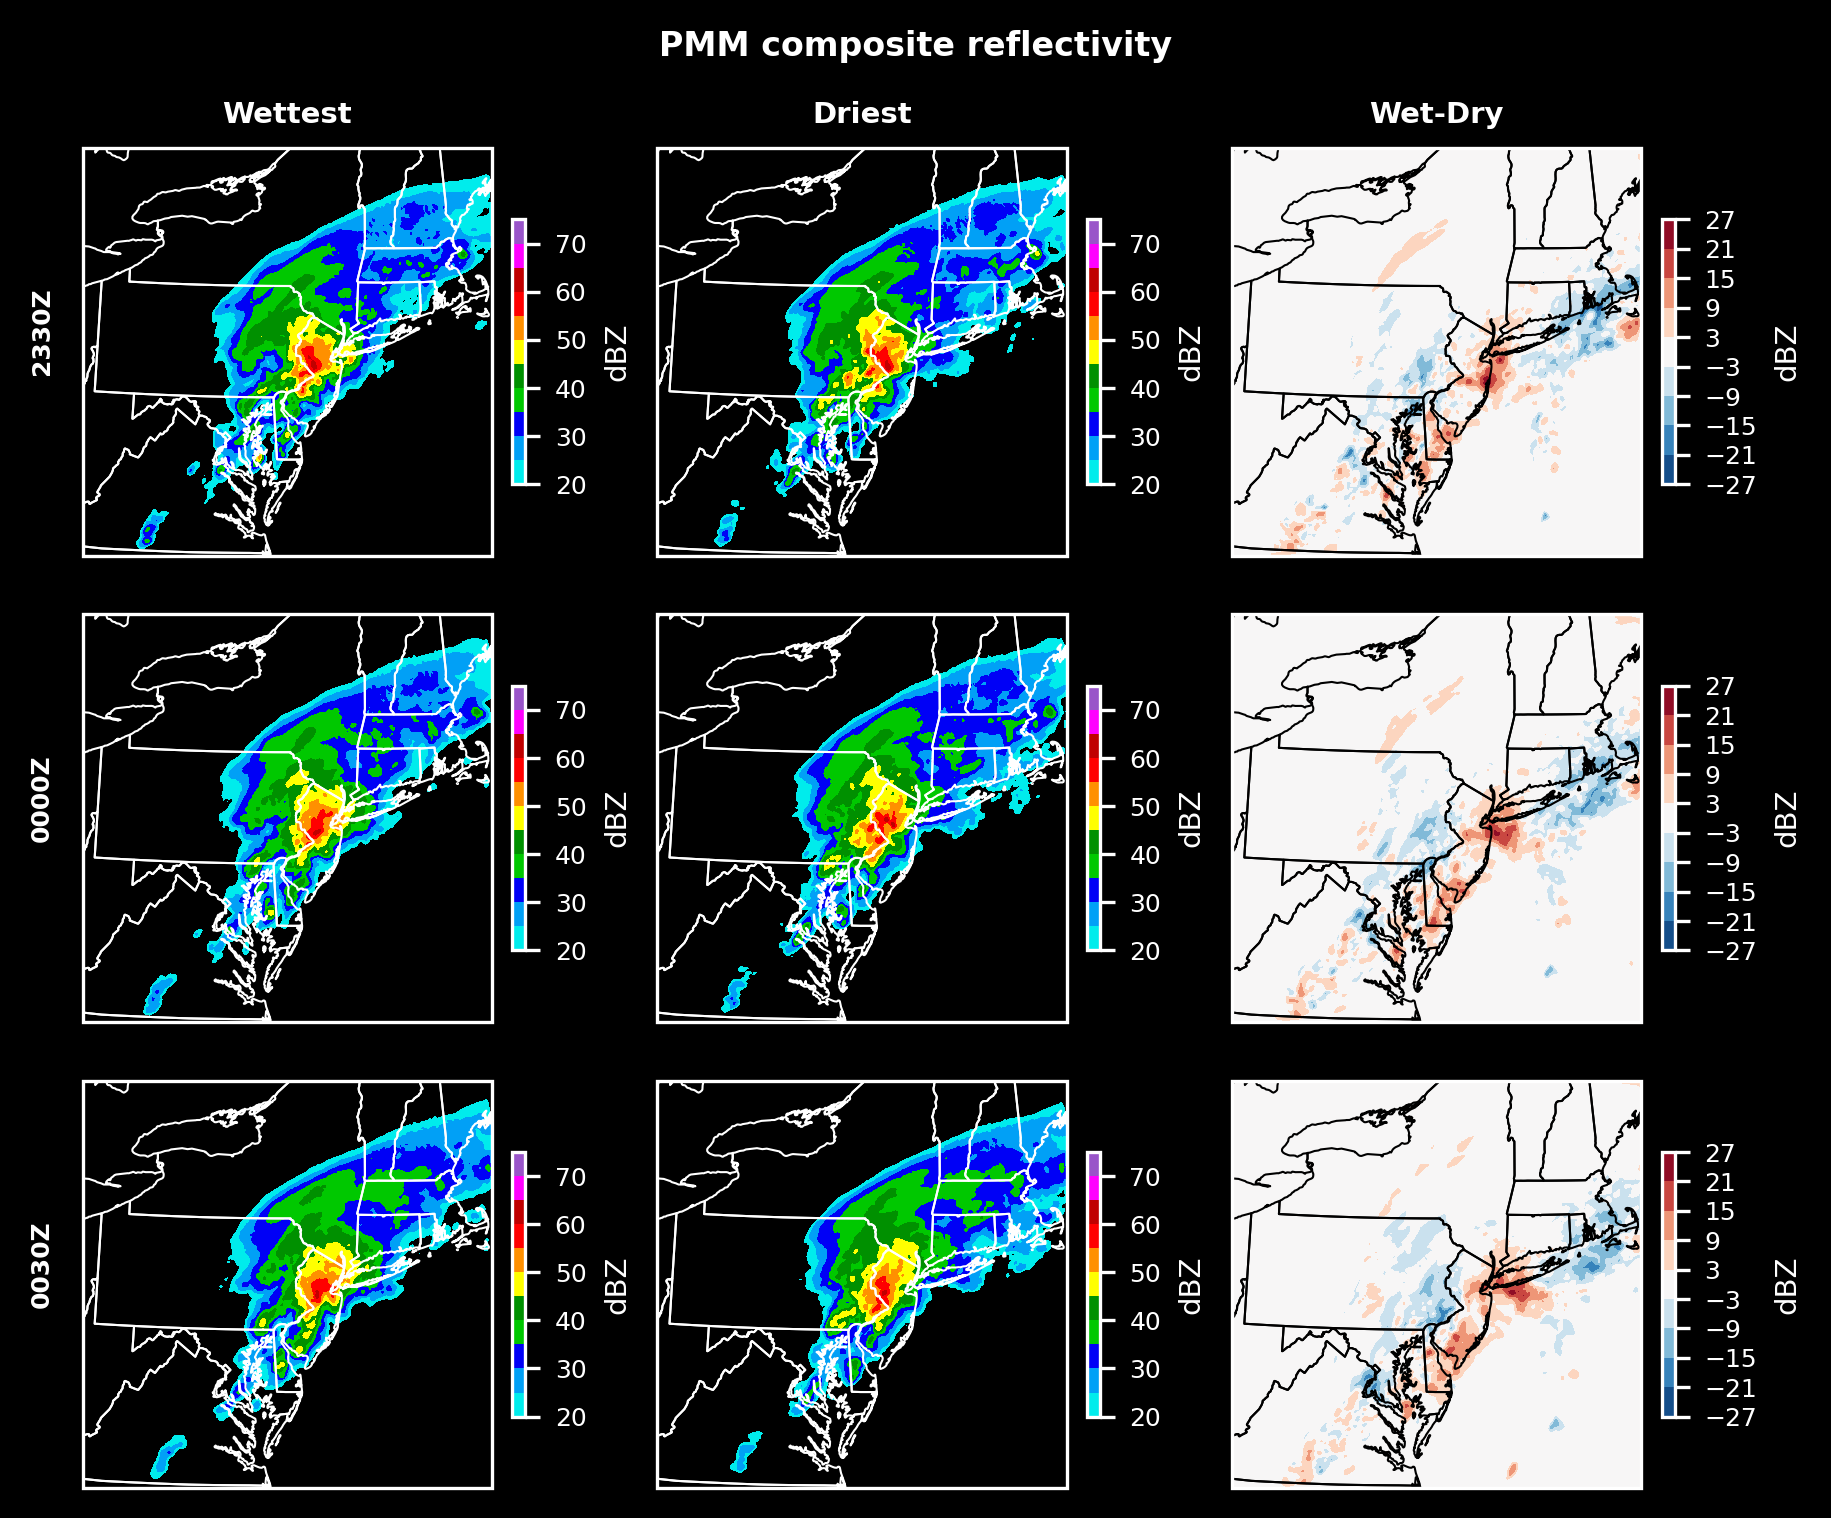

In [45]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

ctable = ctables.registry.get_colortable("NWSReflectivity")

plt.style.use("dark_background")

linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
z = []
for t in range(0,3,1):
    for dbz in [dbz_wet,dbz_dry,dbz_diff]:
        z.append(dbz.isel(time=t))
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,5),sharey=True)

for i,ax in enumerate(axes.flatten()):
    ax.set_ylabel("test")
    if(i%3 != 2):
        p = ax.contourf(lon,lat,pmm(z[i]).unstack(),
                        colors=ctable(np.linspace(0,0.92,11)),
                        transform=ccrs.PlateCarree(),levels=np.arange(20,76,5)
                        )
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
        cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    else:
        p = ax.contourf(lon,lat,z[i].unstack(),
                        transform=ccrs.PlateCarree(),
                        cmap="RdBu_r",levels=range(-27,28,6))
        # m = ax.contourf(lon,lat,dbz_mask.isel(time=i//3),colors="none",levels=[0.5,1.5],
        #                 hatches=["////////",""],transform=ccrs.PlateCarree())
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="black")
        cbar = plt.colorbar(p,ax=ax,shrink=0.6,ticks=range(-27,28,6))

    cbar.ax.tick_params(labelsize=6)
    cbar.set_label("dBZ",fontsize=7)

    if(i<=2):
        ax.set_title(titles[i],fontsize=7, fontweight="bold")

axes[0,0].text(-0.07,0.55,"2330Z",transform=axes[0,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")
axes[1,0].text(-0.07,0.55,"0000Z",transform=axes[1,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")
axes[2,0].text(-0.07,0.55,"0030Z",transform=axes[2,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")


plt.suptitle("PMM composite reflectivity",fontsize=8,fontweight="bold")

plt.show()

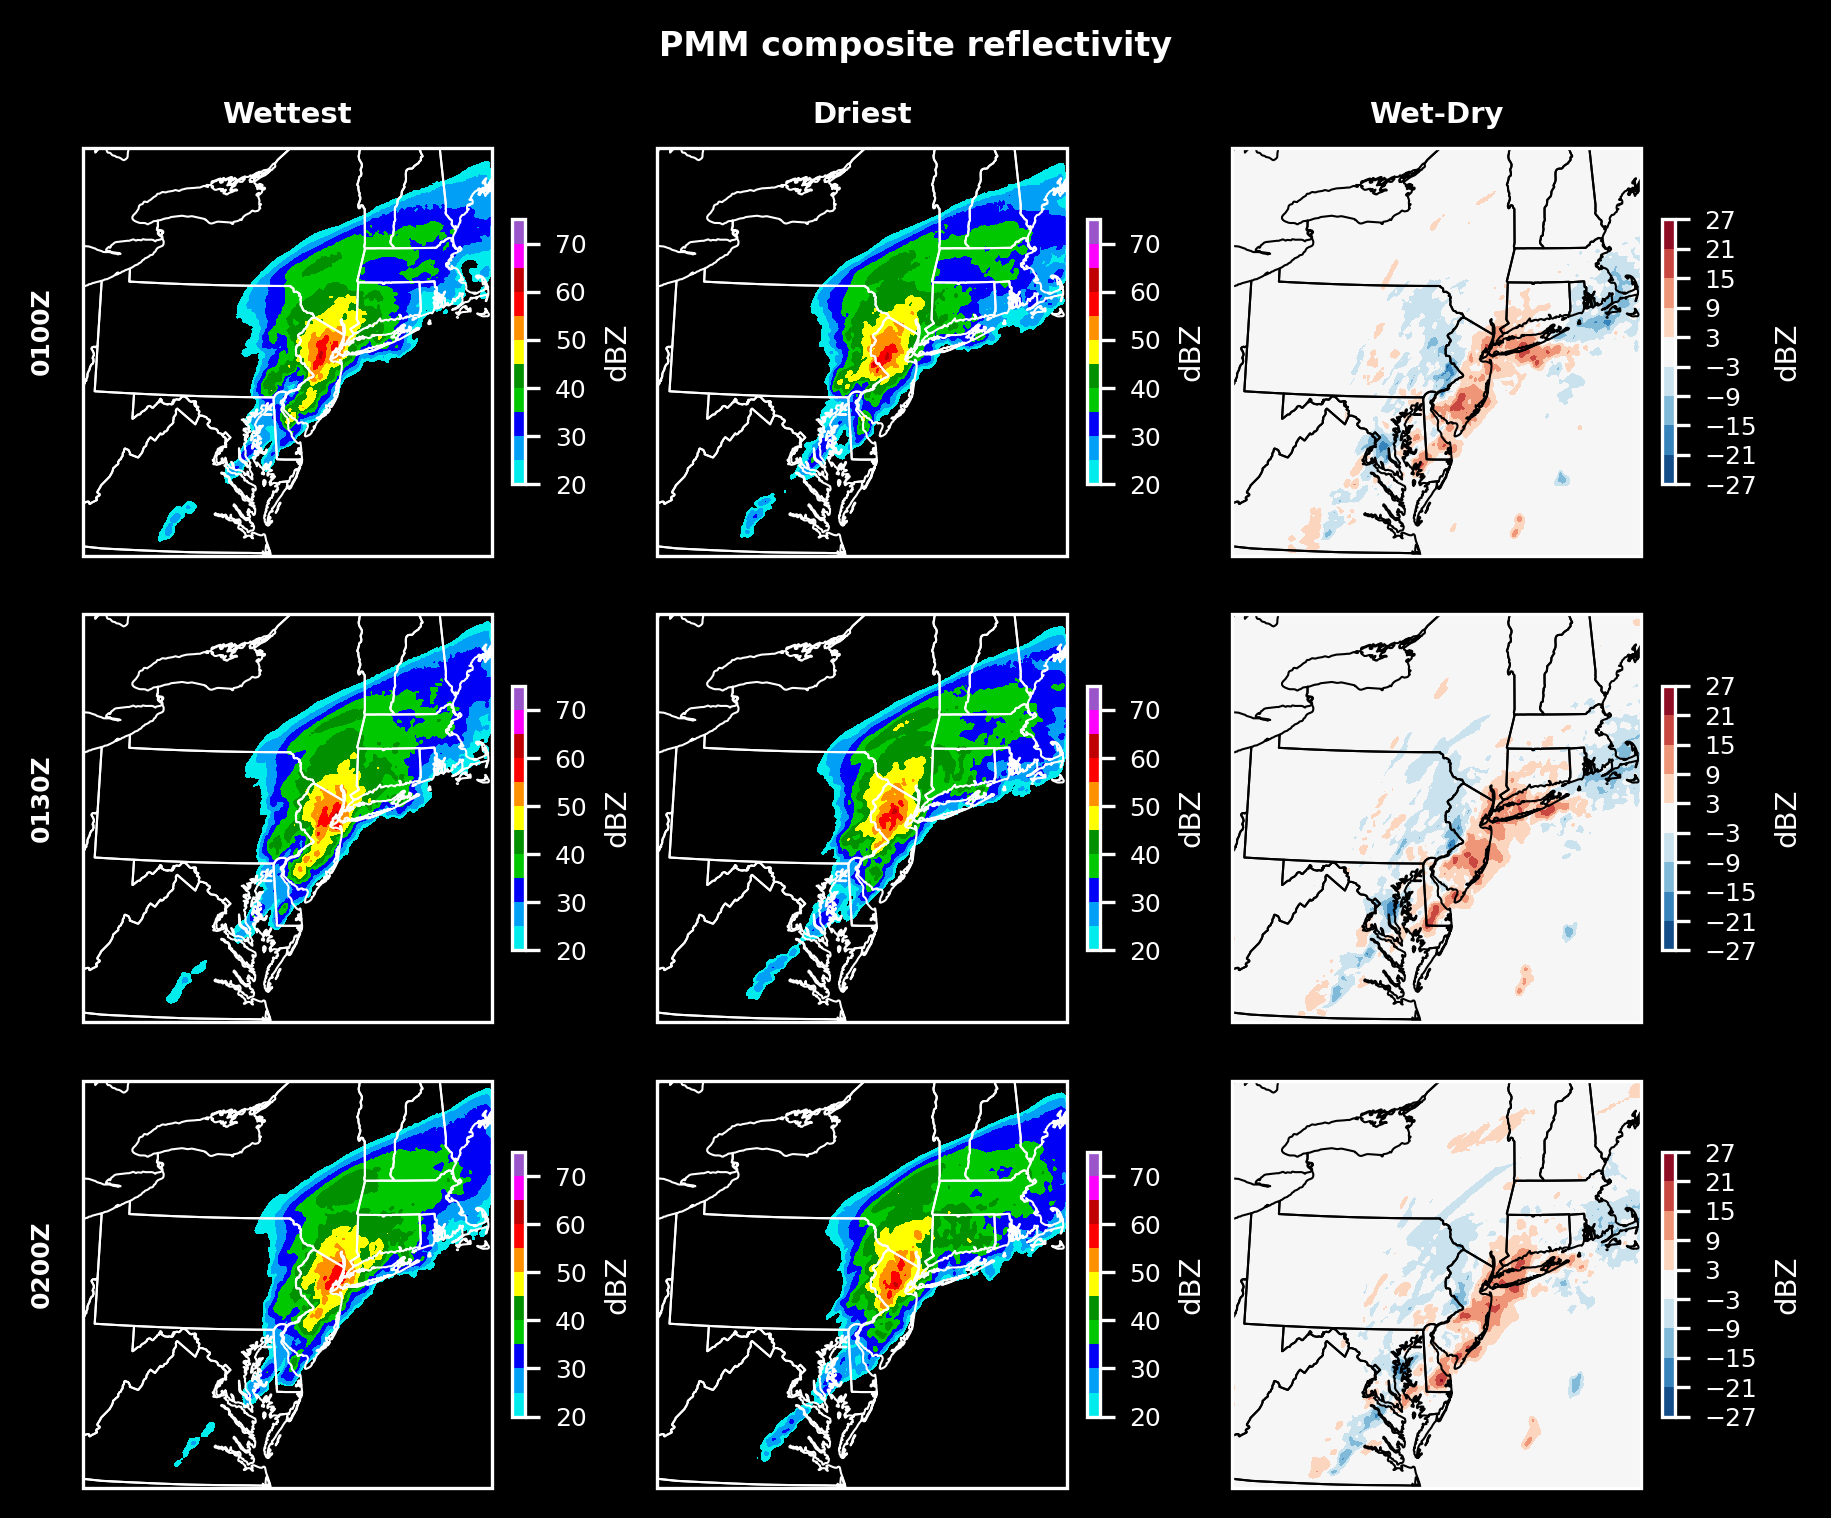

In [43]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

ctable = ctables.registry.get_colortable("NWSReflectivity")

plt.style.use("dark_background")

linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
z = []
for t in range(3,6,1):
    for dbz in [dbz_wet,dbz_dry,dbz_diff]:
        z.append(dbz.isel(time=t))
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,5),sharey=True)

for i,ax in enumerate(axes.flatten()):
    ax.set_ylabel("test")
    if(i%3 != 2):
        p = ax.contourf(lon,lat,pmm(z[i]).unstack(),
                        colors=ctable(np.linspace(0,0.92,11)),
                        transform=ccrs.PlateCarree(),levels=np.arange(20,76,5)
                        )
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
        cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    else:
        p = ax.contourf(lon,lat,z[i].unstack(),
                        transform=ccrs.PlateCarree(),
                        cmap="RdBu_r",levels=range(-27,28,6))
        # m = ax.contourf(lon,lat,dbz_mask.isel(time=i//3),colors="none",levels=[0.5,1.5],
        #                 hatches=["////////",""],transform=ccrs.PlateCarree())
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="black")
        cbar = plt.colorbar(p,ax=ax,shrink=0.6,ticks=range(-27,28,6))

    cbar.ax.tick_params(labelsize=6)
    cbar.set_label("dBZ",fontsize=7)

    if(i<=2):
        ax.set_title(titles[i],fontsize=7, fontweight="bold")

axes[0,0].text(-0.07,0.55,"0100Z",transform=axes[0,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")
axes[1,0].text(-0.07,0.55,"0130Z",transform=axes[1,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")
axes[2,0].text(-0.07,0.55,"0200Z",transform=axes[2,0].transAxes,
               rotation="vertical",rotation_mode="anchor",va="bottom",ha="center",
               fontsize=6,fontweight="bold")


plt.suptitle("PMM composite reflectivity",fontsize=8,fontweight="bold")

plt.show()

### Precip & UH

In [12]:
# We actually already have the 01-02 UTC rainfall stored as a list
# of xarray datasets, so we can just use that.

rain_all = xr.concat(
    [r for r in rain_1to2Z], dim=init).stack(run=("ne", "init")
).chunk({"run":-1})

# repeat for wet & dry ensemble members
rain_wet = xr.concat([fix_ne(e.rain) for e in ens_wet], dim=init).stack(
    run=("ne", "init")
)
rain_dry = xr.concat([fix_ne(e.rain) for e in ens_dry], dim=init).stack(
    run=("ne", "init")
)

# Get the 01-02 UTC rainfall for rain_wet & rain_dry
rain_wet = rain_wet.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")).sum(
    dim="time"
)
rain_dry = rain_dry.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")).sum(
    dim="time"
)

In [13]:
# Repeat for UH
uh_all = xr.concat([e.uh_0to2 for e in ens], dim=init).stack(run=("ne", "init")).chunk(
    {"run": -1}
)
uh_wet = xr.concat([fix_ne(e.uh_0to2) for e in ens_wet], dim=init).stack(
    run=("ne", "init")
)
uh_dry = xr.concat([fix_ne(e.uh_0to2) for e in ens_dry], dim=init).stack(
    run=("ne", "init")
)

uh_all = get_max_uh(uh_all)
uh_wet = get_max_uh(uh_wet)
uh_dry = get_max_uh(uh_dry)

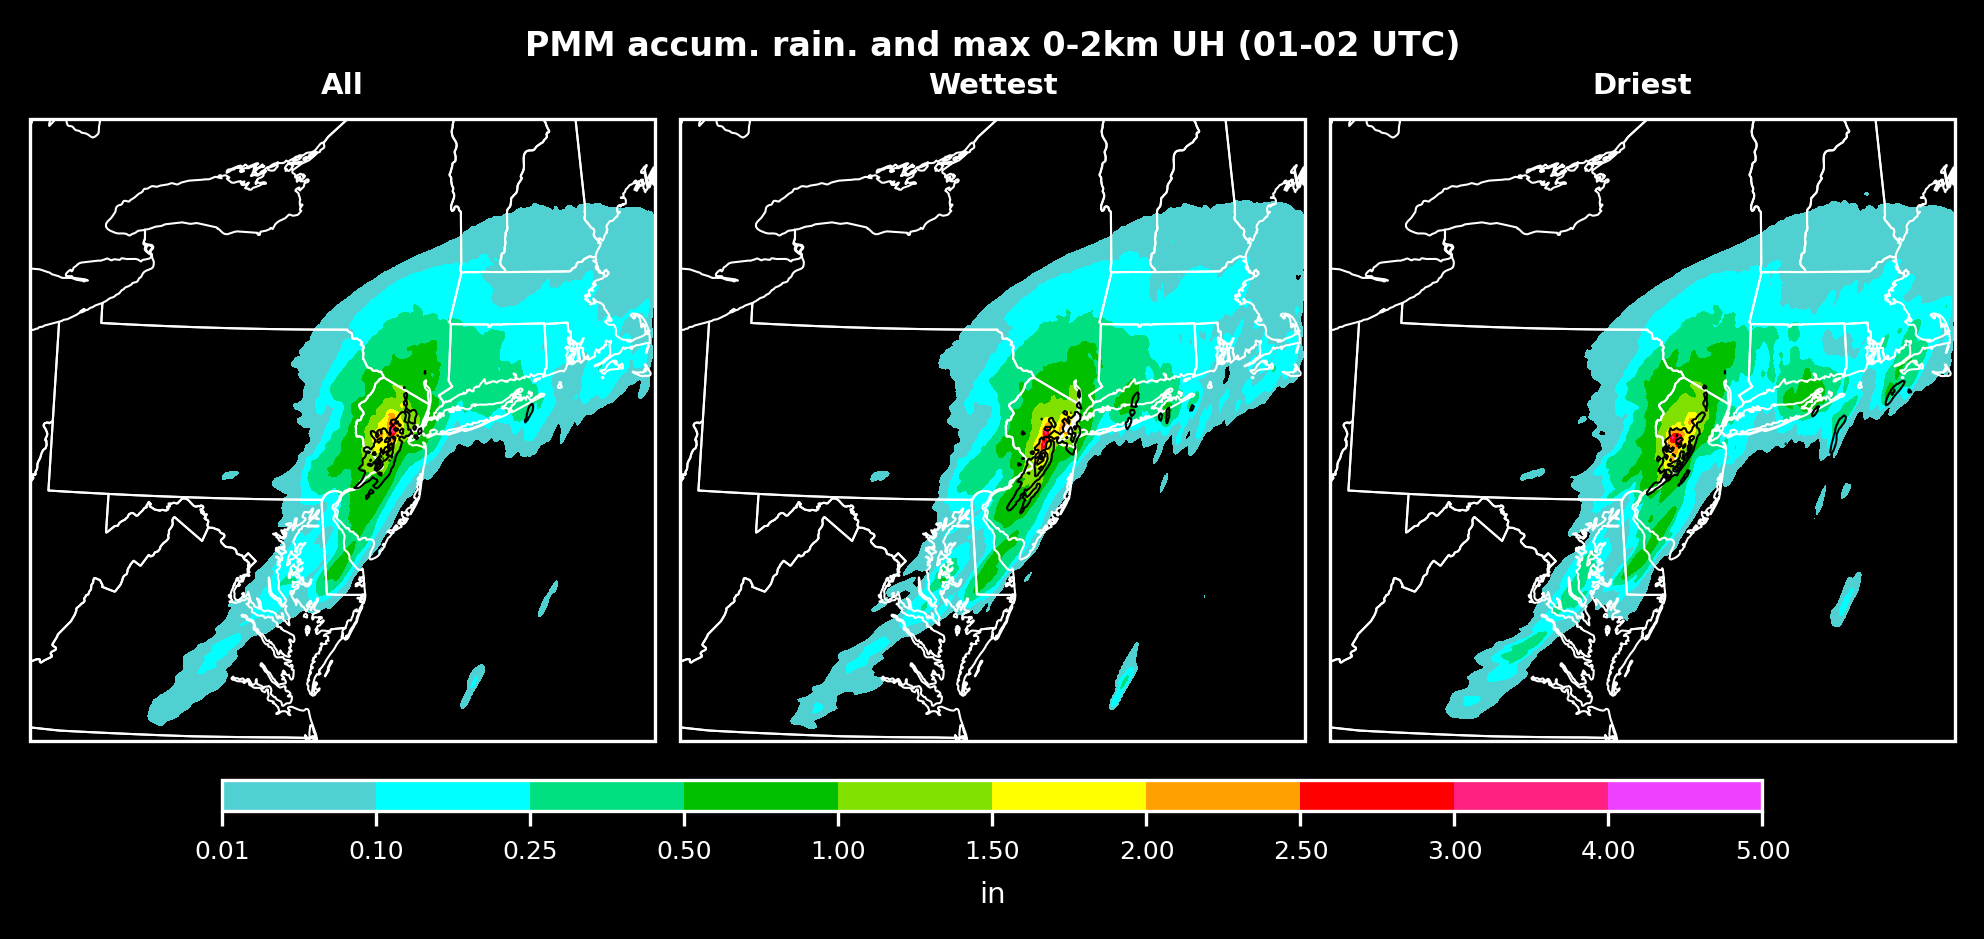

In [24]:
# Make plots of the pmm_rain with pmm_uh_max contoured over it
rain_values = [pmm(r).load() for r in [rain_all, rain_wet, rain_dry]]
uh_values = [pmm(u).load() for u in [uh_all, uh_wet, uh_dry]]
titles = ["All", "Wettest", "Driest"]
levels = [0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5]

fig, axes = plt.subplots(
    1,
    3,
    figsize=(6.5, 3),
    dpi=300,
    subplot_kw=dict(projection=proj),
    layout="constrained",
)

for i, ax in enumerate(axes.flatten()):
    p = ax.contourf(
        lon,
        lat,
        rain_values[i],
        colors=precip_cmap.colors[1:12],
        levels=levels,
        transform=ccrs.PlateCarree(),
    )

    # Add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    # Contour uh
    c = ax.contour(
    lon,
    lat,
    uh_values[i],
    colors="black",
    levels=range(5, 40, 10),
    linewidths=0.5,
    transform=ccrs.PlateCarree(),
    )

    ax.set_title(titles[i], fontsize=7, fontweight="bold")

# Add colorbar
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=50, orientation= "horizontal",)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
cbar.set_ticks(levels)

plt.suptitle("PMM accum. rain. and max 0-2km UH (01-02 UTC)", fontsize=8,
              fontweight="bold")

plt.show()

In [60]:
# Perform the bootstrapping
result = bootstrap_pmm_difference(rain_all, sample_size=20, iterations=1000)

# Compute the results
result_computed = result.compute()

# Now `result_computed` holds the final differences

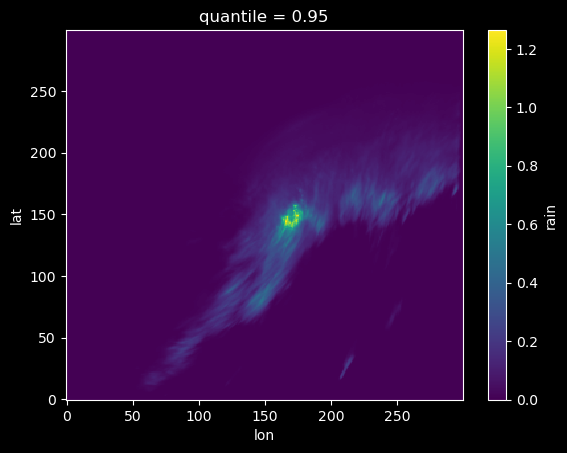

In [63]:
result_computed.quantile(0.95,dim="iteration").plot()